# 1. Motivation

## 1.1 How and why we want to analyze the cryptocurrency developer community

Cryptocurrencies are maybe the most interesting economic phenomenon in recent years. Being able to basically generate money by running computer algorithms and doing very little work after an initial setup is a very tempting outlook for everybody. And even though the possible uses of bitcoin and co. to actually buy stuff from the real world are still limited, more and more people have jumped on the train of mining and trading with cryptocurrencies, resulting in huge value increases. In 2017 alone, the worth of bitcoin, the oldest, most common and most valuable cryptocurrency, has increased more than tenfold, [eclipsing the 10,000$ mark on November 28th](http://markets.businessinsider.com/currencies/news/bitcoin-price-clears-10000-2017-11-1009817597). This has lead to some interesting developments in recent time, such as prices for some computer hardware, especially powerful graphics cards, [almost doubling in the last year](https://www.digitaltrends.com/computing/cryptocurrency-mining-graphics-card-prices/).

But just as more and more people have begun to join the virtual gold rush and try their luck at mining bitcoins with their home equipment, other groups of programming enthusiasts and cryptology specialists have started to create alternatives to the almighty bitcoin, resulting in hundreds of more or less valuable virtual forms of money being available and ready to be mined. In order to do so, one has to get a piece of source code from the internet, which is most of the time stored on github.

Github itself, again, is not only a way to share and collaborate on programmin projects, but also has functions that make it a social platform, such as the ability to follow another user or to "like" a certain project or code reporitory. This second act is called "stargazing" in github terms. And that's where data science and social graphs come into play. We want to find out, how the stargazer community of different cryptocurrencies is shaped. In order to do so, we need to get the necessary information about the code repositories via the github api and then analyze it with tools of network science. 

We also want to take a look at the Wikipedia entries of some cryptocurrencies and try to find differences in word choice, etc. Because most of the digital currencies are very new or small, the number of Wikipedia entries is very limited.

> *TL;DR:* **We want to analyze the community of cryptocurrency enthusiasts on github and the corresponding Wikipedia pages. We want to do this, because it is a booming, highly discussed industry that could change the face of the financial world**

## 1.2 Dataset description

The dataset that we collected and analyzed contains the github repositories for over 300 cryptocurrencies and their stargazers. Also, we have information on which of the users that starred one of the repositories follow each other. The second piece of data are the Wikipedia pages to some of the aforementioned currencies.

## 1.3 Goals for user experience

With the website, we want to provide insight to several questions about the cryptocurrency community:

* How is github relevance connected to a currency's market value?
* What are the similarities between several cryptocurrencies' following bases?
* Are there communities within the group of users starring cryptocurrency repositories?
* What can we gain from analyzing the Wikipedia pages of certain currencies?

# 2. The data

## 2.1 Dataset collection and setup

### 2.1.1 Network data collection

To gain an insight on which cryptocurrencies exist and where to find their source code, we first need a place to gain this information from. On [coinmarketcap.com](https://coinmarketcap.com/), we can find all the cryptocurrencies' names:




In [ ]:
from bs4 import BeautifulSoup
import urllib.request
from lxml import etree
import pickle
import os
import glob
import re
import sys

In [ ]:
def getNames():
    url = r'https://coinmarketcap.com/coins/views/all/'
    response = urllib.request.urlopen(url)
    # The package BeautifulSoup allows us to extract things from the HTML page
    soup = BeautifulSoup(response, 'lxml')
    names_divs = soup.findAll('a', { 'class' : 'currency-name-container' })
    # Create list of names
    names_text = [div.text for div in names_divs]
    return names_text

Now, we need to clean up the currency names so that they all match the same standard

In [5]:
crypto_currency_names = [name.replace(' ','-').lower() for name in getNames()]
N = len(crypto_currency_names)

print('There are ' + str(N) + ' crypto-currencies.   -source coinmarketcap.com')
print(crypto_currency_names[0:5]) # (These are the top five)

There are 903 crypto-currencies.   -source coinmarketcap.com
['bitcoin', 'ethereum', 'bitcoin-cash', 'ripple', 'litecoin']


As a next step, we need to find the actual github repositories for the currencies. The site [coingecko.com](https://www.coingecko.com/en) allows us to get this information (Note that not all cryptocurrencies have github repositories, thus we will end up with a shorter list than before):

In [3]:
def getUrl(crypto_name):
    # Build URL
    url = r'https://www.coingecko.com/en/coins/' + crypto_name + r'/developer'
    # Open page
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    # Extract important stuff with BeautifulSoup
    soup = BeautifulSoup(html, 'lxml')
    try:
        base_url = soup.find('a', href=True, text='Code Repository')['href']
        return base_url
    except TypeError:
        return None
        

We then create a dictionary with all the github urls

In [6]:
# Create dict of  {cryto-currencey: github-url,} eg {'bitcoin: https://github.com/bitcoin/bitcoin}
cryptoName_gitUrl_dict = {}

for i,name in enumerate(crypto_currency_names):
    try: 
        git_url = getUrl(name)
    except:
        git_url = None

    cryptoName_gitUrl_dict[name] = git_url
    
    # Prints progress (%) to standard output
    if (i % 90 == 0):
        print(str("\r{0}".format(round((float(i)/N)*100),0)) + r'% ...')

0% ...
10% ...
20% ...
30% ...
40% ...
50% ...
60% ...
70% ...
80% ...
90% ...
100% ...


In [8]:
# Pickle dict to current directory. {'bitcoin: https://github.com/bitcoin/bitcoin}
with open('./cryptoName_gitUrl_dict.pickle', 'wb') as handle:
    pickle.dump(cryptoName_gitUrl_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

We can now perform a check on how many pages we got:

In [9]:
nones = {k:v for k,v in cryptoName_gitUrl_dict.items() if v is None}
print('Number of crypto-currencies without a Github repo: ' + str(len(nones)))

Number of crypto-currencies without a Github repo: 479


In [10]:
# Inspect the crypto-currencies that DON'T have a GitHub repository.
for crypto in nones:
    print(crypto)

stellar-lumens
byteball-bytes
metaverse-etp
vechain
b3coin
cryptonex
kucoin-shares
i/o-coin
atbcoin
decent
crown
e-coin
peerplays
the-champcoin
bitcloud
compcoin
voxels
sphere
pascal-coin
credence-coin
kore
global-curren...
myriad
thegcccoin
neutron
artbyte
equitrader
europecoin
bela
internet-of-p...
hempcoin
xgox
xp
condensate
e-gulden
putincoin
atmos
zennies
zoin
supercoin
mao-zedong
draftcoin
growers-inter...
zephyr
greencoin
eboost
bytecent
pure
helleniccoin
netko
hicoin
kekcoin
briacoin
linx
happycoin
allsafe
sacoin
footy-cash
unify
shield
zero
gcoin
solaris
42-coin
inflationcoin
smileycoin
elementrem
blakestar
universal-cur...
tychocoin
altcommunity-...
goldreserve
808coin
valorbit
atomic-coin
litebar
postcoin
scorecoin
kilocoin
ecocoin
prototanium
devcoin
elcoin
chancoin
reecoin
evotion
wyvern
womencoin
prcoin
francs
coinonatx
pascal-lite
virta-unique-...
tristar-coin
doubloon
litecoin-plus
nevacoin
beatcoin
eryllium
printerium
bitcurrency
morningstar
magnum
selfiecoin
project-x

This does look like a lot of currencies we don't catch (>50%), but by inspection of the crypto-currencies that do not have a github repository it can be seen that these crypto-currencies are those with the lower market caps.<br>
For example in the top 50 crypto-currencies by marketcap only 4 do not have an active git repository.
<br><br>

*These are:*
* Stellar-Lumens (no. 17 by market cap)
* Byteball-btyes (no. 31 by market cap)
* Metaverse-etp (no. 38 by market cap)
* Vechain (no. 47 by market cap)

<br>
**Note that over 95% of  the marketcap  of crypto-currencies is in the top 10 crypto currencies**

We only want the crypto-currencies that have a Github repository.
Hence we remove the crypto-currencies without a Github repo from the dictionary.

In [11]:
cryptoName_gitUrl_dict = {k:v for k,v in cryptoName_gitUrl_dict.items() if v is not None}

In [13]:
# Re-pickle dict to current directory without "None" values() {'bitcoin: https://github.com/bitcoin/bitcoin}
with open('./cryptoName_gitUrl_dict.pickle', 'wb') as handle:
    pickle.dump(cryptoName_gitUrl_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Before we finally download the data from github, we need to change a few little things about the url dictionary:

In [70]:
# Convert dictionary to a list of tuples for future ease of use
# Get full name of repo (from the https url)
cryptoName_gitUrl = [(k, v.replace('https://github.com/','')) for k, v in cryptoName_gitUrl_dict.items()]
print(cryptoName_gitUrl[0])  # Print first 
print(cryptoName_gitUrl[-1])  # Print last

('bitcoin', 'bitcoin/bitcoin')
('peoplecoin', 'peopleproject/people')


In [72]:
# Exclude the currency 'bitbucket' as it will throw an error
cryptoName_gitUrl = [(crypto_name, repo_name) for  (crypto_name, repo_name) in cryptoName_gitUrl if 'bitbucket' not in repo_name]
for (crypto_name, repo_name) in cryptoName_gitUrl:
    print(repo_name)

bitcoin/bitcoin
ethereum/go-ethereum
Bitcoin-ABC/bitcoin-abc
ripple/rippled
litecoin-project/litecoin
dashpay/dash
neo-project/neo
monero-project/bitmonero
iotaledger/wallet
NewEconomyMovement/NemCommunityClient
ethereumproject/go-ethereum
LiskHQ/lisk
qtumproject/qtum
zcash/zcash
HcashOrg/Hshare
input-output-hk/cardano-sl
bitconnectcoin/bitconnectcoin
wavesplatform/Waves
stratisproject/Breeze
ArkEcosystem/ark-node
steemit/steem
BitShares/bitshares-2
jl777/komodo
amjuarez/bytecoin
decred/dcrd
vertcoin/vertcoin
PIVX-Project/PIVX
monacoinproject/monacoin
FactomProject/factomd
dogecoin/dogecoin
laowais/bitcoindark
NebulousLabs/Sia
syscoin/syscoin2
gamers-coin/GameCredits
atcsecure/blocknet
LykkeCity/LykkeX
vergecurrency/verge
gxchain/gxb-core
digibyte/digibyte
PURAcore/PURA
zcoinofficial/zcoin
particl/particl-core
ZencashOfficial/zen
Nexusoft/Nexus
FairCoinTeam/fair-coin
NAVCoin/navcoin-core
/bitdeal/
ubiq/go-ubiq
NeblioTeam/-
CounterpartyXCP/counterparty-lib
NoLimitCoin/NoLimitCoin
peerco

Now we are finally ready to get the data we will be working with. By using the [github API](https://developer.github.com/v3/) and the package [PyGithub](https://github.com/PyGithub/PyGithub) we can get all the needed information about the cryptocurrencies' repositories. We will define a function that gives us the desired output:

In [73]:
# Use Personal Access Token
api_token = '9860490c5562541b51646a7f909e58e3ab420de5'
gh = Github(api_token)

In [74]:
# Function to create dictionary of repository objects 
def Repo_Objects(cryptoName_gitUrl):
    # Initialize output dictionary
    crypto_repo_dict = {}
    
    # Go through the list of currencies
    for i,vals in enumerate(cryptoName_gitUrl):
        (crypto_name, owner_repo) = vals
        try:
            owner,repo = owner_repo.split('/')
        except ValueError:
            pass
        
        repo_object = None
        
        # Progress update every 50 iterations
        if i % 50 == 0:
            print(str(i) + ' / ' + str(len(cryptoName_gitUrl)))
        
        # Download the repo
        try:  
            owner = gh.get_organization(owner) # In the case the repo was created by an 'organisation'
        except:
            pass

        try:  
            owner = gh.get_user(owner) # In the case the repo was created by a 'user'
        except:
            pass

        try:
            repo_object = owner.get_repo(repo)
        except:
            pass
            # The error is an "UnknownObjectException" (but python doesn't know what that is) so throws
            # an error with "except: UnknownObjectException:"            
            
        print(repo_object)
        crypto_repo_dict[crypto_name] = repo_object
                  
    return crypto_repo_dict

In [75]:
# Downloading process
crypto_repo_dict = Repo_Objects(cryptoName_gitUrl)
print('************************')
print(crypto_repo_dict)
print('************************')

0 / 420
Repository(full_name="bitcoin/bitcoin")
Repository(full_name="ethereum/go-ethereum")
Repository(full_name="Bitcoin-ABC/bitcoin-abc")
Repository(full_name="ripple/rippled")
Repository(full_name="litecoin-project/litecoin")
Repository(full_name="dashpay/dash")
Repository(full_name="neo-project/neo")
Repository(full_name="monero-project/monero")
Repository(full_name="iotaledger/wallet")
None
Repository(full_name="ethereumproject/go-ethereum")
Repository(full_name="LiskHQ/lisk")
Repository(full_name="qtumproject/qtum")
Repository(full_name="zcash/zcash")
Repository(full_name="HcashOrg/Hshare")
Repository(full_name="input-output-hk/cardano-sl")
Repository(full_name="bitconnectcoin/bitconnectcoin")
Repository(full_name="wavesplatform/Waves")
Repository(full_name="stratisproject/Breeze")
Repository(full_name="ArkEcosystem/ark-node")
Repository(full_name="steemit/steem")
Repository(full_name="bitshares/bitshares-core")
Repository(full_name="jl777/komodo")
Repository(full_name="amjuarez

Repository(full_name="startcoin-project/startcoin")
Repository(full_name="megacoin/megacoin")
Repository(full_name="LuckBash/Bash")
Repository(full_name="ArcticCore/arcticcoin")
Repository(full_name="CryptopiaNZ/DOT")
Repository(full_name="pirl/pirl")
Repository(full_name="CryptoCoderz/Espers")
Repository(full_name="MiniblockchainProject/Cryptonite")
Repository(full_name="RenosCoin/RenosCoin")
Repository(full_name="TrezarCoin/TrezarCoin")
Repository(full_name="bitcoinz-pod/bitcoinz")
200 / 420
Repository(full_name="unitusdev/unitus")
Repository(full_name="Signatum/SXT")
Repository(full_name="AdzCoin/adzcoin")
Repository(full_name="hyperstake/HyperStake")
Repository(full_name="chainworksindustries/influx")
Repository(full_name="bitzeny/bitzeny")
Repository(full_name="fastcoinproject/fastcoin")
Repository(full_name="cryptocarbon/web3.js")
Repository(full_name="Kracko/ultracoin-2")
Repository(full_name="machinecoin-project/machinecoin-core")
Repository(full_name="CryptoCoderz/INSN")
Repos

Repository(full_name="owlchain/owlchain-core")
Repository(full_name="lazyboozer/Desire")
Repository(full_name="coingulf/gulfcoin")
None
Repository(full_name="qbasicer/TerraNova")
Repository(full_name="bitbasecoin/bitbase")
Repository(full_name="vulcanodev/Vulcano")
Repository(full_name="BUZZCOINproject/buzzcoin")
Repository(full_name="Bit-Net/VpnCoin")
Repository(full_name="wmcorless/paccoin")
None
Repository(full_name="forcechain/Force-Blockchain")
Repository(full_name="NicoDFS/DFSCoin")
Repository(full_name="cybernetik7/StarCash-Network-2.0")
Repository(full_name="flashcoin-io/flashcoin.io-cas-client")
Repository(full_name="stronghands/stronghands")
Repository(full_name="CoinProjects/AmsterdamCoin")
Repository(full_name="adcoin-project/AdCoin")
Repository(full_name="namocoin/NamoCoin")
400 / 420
Repository(full_name="longdiete/Proteania")
Repository(full_name="acncoin/Avoncoin-Project")
Repository(full_name="runnersdev/runners-source")
Repository(full_name="moneta-project/moneta")
Re

In [76]:
# Pickle dict to current directory 
with open('./crypto_repo_dict.pickle', 'wb') as handle:
    pickle.dump(crypto_repo_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(crypto_repo_dict)

{'bitcoin': Repository(full_name="bitcoin/bitcoin"), 'ethereum': Repository(full_name="ethereum/go-ethereum"), 'bitcoin-cash': Repository(full_name="Bitcoin-ABC/bitcoin-abc"), 'ripple': Repository(full_name="ripple/rippled"), 'litecoin': Repository(full_name="litecoin-project/litecoin"), 'dash': Repository(full_name="dashpay/dash"), 'neo': Repository(full_name="neo-project/neo"), 'monero': Repository(full_name="monero-project/monero"), 'iota': Repository(full_name="iotaledger/wallet"), 'nem': None, 'ethereum-classic': Repository(full_name="ethereumproject/go-ethereum"), 'lisk': Repository(full_name="LiskHQ/lisk"), 'qtum': Repository(full_name="qtumproject/qtum"), 'zcash': Repository(full_name="zcash/zcash"), 'hshare': Repository(full_name="HcashOrg/Hshare"), 'cardano': Repository(full_name="input-output-hk/cardano-sl"), 'bitconnect': Repository(full_name="bitconnectcoin/bitconnectcoin"), 'waves': Repository(full_name="wavesplatform/Waves"), 'stratis': Repository(full_name="stratisproje

In [78]:
# Remove failed currencies
crypto_repo_dict = {k:v for k, v in crypto_repo_dict.items() if v is not None}

In [79]:
print('There are now only ' + str(len(crypto_repo_dict)) + ' valid crypto currencies with repositorys')

There are now only 395 valid crypto currencies with repositorys


For every currency that didn't throw an error (395), we now have a repository file from which we can extract several things, e.g. its Stargazers, for which we will define another function:

In [77]:
def Star_Gazers(crypto_repo_dict):
    crypto_stargazers_dict = {}
    
    for i,(crypto_name, repo_object) in enumerate(crypto_repo_dict.items()):
        
        # Keep track of progess
        if i % 50 == 0:
            print(str(i) + ' / ' + str(len(crypto_repo_dict)))
                  
        # Add list of stargazers (users) to dict for each crypto-currency
        crypto_stargazers_dict[crypto_name] = list(repo_object.get_stargazers())
                  
    return crypto_stargazers_dict

In [80]:
# Get list of stargazers for each repository
crypto_stargazers_dict = Star_Gazers(crypto_repo_dict)

0 / 395
50 / 395
100 / 395
150 / 395
200 / 395
250 / 395
300 / 395
350 / 395


In [94]:
with open('./crypto_stargazers_dict.pickle', 'wb') as handle:
    pickle.dump(crypto_stargazers_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [95]:
# The "crypto_stargazers_dict" is a dictionary with the name of the crypto-currencies as the 'key',
# and the list of Pygithub user objects as the 'values' of tthe 'key'.
# Named user documentation: http://pygithub.readthedocs.io/en/latest/github_objects/NamedUser.html
print(crypto_stargazers_dict)

{'bitcoin': [NamedUser(login="ELLIOTTCABLE"), NamedUser(login="methodmissing"), NamedUser(login="oleganza"), NamedUser(login="lukehoersten"), NamedUser(login="hotsyk"), NamedUser(login="1083"), NamedUser(login="jamie"), NamedUser(login="reedlaw"), NamedUser(login="stantont"), NamedUser(login="eduardo"), NamedUser(login="softprops"), NamedUser(login="JamesHarrison"), NamedUser(login="eklitzke"), NamedUser(login="nikolay"), NamedUser(login="mattknox"), NamedUser(login="stinie"), NamedUser(login="adulau"), NamedUser(login="viniciusteles"), NamedUser(login="ncarlson"), NamedUser(login="rjanse"), NamedUser(login="AArnott"), NamedUser(login="jmonteiro"), NamedUser(login="EdwardBetts"), NamedUser(login="lazzarello"), NamedUser(login="alfakini"), NamedUser(login="meantheory"), NamedUser(login="oddlyzen"), NamedUser(login="dshaw"), NamedUser(login="anthonywebb"), NamedUser(login="beppu"), NamedUser(login="johnson"), NamedUser(login="bendiken"), NamedUser(login="gugod"), NamedUser(login="brunojm

### 2.1.2 Network setup

With the data we gained, we can now set up a network with the following properties: 
* **Nodes** can either be **users** or **currencies**. This is specified by a node attribute "Type"
* **Edges** are either of the type **gazes** (User-to-currency) or **follows** (user-to-user)

In [1]:
from github import Github
import networkx as nx
import pickle
import random
import json
import numpy as np
import matplotlib.pyplot as plt 
import re
import itertools as it
import operator
import time
import datetime
from pathlib import Path
import community

In [2]:
# Load data
with open('./crypto_stargazers_dict.pickle', 'rb') as handle:
    crypto_stargazers_dict = pickle.load(handle)
    
Stargaze_Network = nx.DiGraph()

# Setup network
for crypto_name, stargazers_list in crypto_stargazers_dict.items():
    # Add node for the currency (if not already there)
    if crypto_name not in Stargaze_Network.nodes():
        Stargaze_Network.add_node(crypto_name, Type="Currency")
    for user in stargazers_list:
        # add nodes for all stargazers (if not already there)
        if user.login not in Stargaze_Network.nodes():
            Stargaze_Network.add_node(user.login, Type="User")
            
        # add edge from user to currency
        Stargaze_Network.add_edge(user.login, crypto_name, Type="gazes")

In [3]:
# Quick summary of graph so far
print(nx.info(Stargaze_Network)[6:])


Type: DiGraph
Number of nodes: 41211
Number of edges: 57462
Average in degree:   1.3943
Average out degree:   1.3943


In [4]:
# Save the graph
with open('./Stargaze_Network.pickle', 'wb') as handle:
    pickle.dump(Stargaze_Network, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Add links between users**
A edge points from one github user to another if the user follows the other user on github.<br>
Hence,
* edges representing a users "following" are pointing to the user. (from their following to the user)
* edges representing a users "followers" are poining away from the user (from the user to their followers)

By geting the users a user is following for every user in the network and intersecting this with users in the network (as as most of the users a user is following with not have starred any of the github communities) we will be able to create 

In [5]:
# Use Personal Access Token
gh = Github('9860490c5562541b51646a7f909e58e3ab420de5')

with open('./crypto_stargazers_dict.pickle', 'rb') as handle:
    crypto_stargazers_dict = pickle.load(handle)
    
with open('./Stargaze_Network.pickle', 'rb') as handle:
    Stargaze_Network = pickle.load(handle)
users_set = set(Stargaze_Network.nodes)

In [6]:
# List of lists of stargazers of each crypto-currency
user_list_of_lists = [stargazers_list for crypto_name, stargazers_list in crypto_stargazers_dict.items()]

# Convert lists of lists to one long list (will contain duplicates)
flat_user_list = [user_object for user_list in user_list_of_lists for user_object in user_list]

# Replace PyGitHub user objects with the username of the user-object 
login_userobject_list = [(user.login,user) for user in flat_user_list]

# Remove duplicates
login_userobject_list = list(dict(login_userobject_list).items()) 

print('Number of unique users: ',len(login_userobject_list))

Number of unique users:  40825


The section below was run in chunks taking over 70 hours of  runtime due to the slow request time for the GitHub API requests. 
We could not run this code block in the explainer notebook as it would take three days hence this section has no output.

In [ ]:
t_start = time.time()
following_dict = {}

for i,(login, user_object) in enumerate(login_userobject_list):
   
    try:
        # Calling the GitHub API to get the users a user follows
         # Adds the users followers and following into dicts. The key is the the users login
        following_dict[login] = [follower.login for follower in gh.get_user(user_object.login).get_following() if follower.login in users_set]
    except:
        print(i)

    # Pickle "following_dict" every 1000 users (we have 40824 users so  this will result in 41 files)
    if i in range(1000,40825,1000) or i == 40824:
        filename = './' + 'following_dict' + '__' + str(i-1000) + '_TO_' + str(i) + '.pickle'
        with open(filename, 'wb') as handle:
            pickle.dump(following_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(filename)
        following_dict = {}
        now = time.time()
        print('i: ', i, '  | Runtime: ', now-t_start)

In [7]:
pathlist = Path('./following/').glob('**/*.pickle')
Following_Network = nx.DiGraph()

# Iterate over the 41 pickled files
for i,path in enumerate(pathlist):
    with open(str(path), 'rb') as handle:
        following = pickle.load(handle)

        for user_login in following:
            for followed_user in following[user_login]:
                # Add the followed users as edges from a given user
                Following_Network.add_edge(user_login, followed_user, Type="following")

In [8]:
# Save the graph
with open('./Following_Network.pickle', 'wb') as handle:
    pickle.dump(Following_Network, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
print(nx.info(Following_Network)[6:])


Type: DiGraph
Number of nodes: 24404
Number of edges: 77117
Average in degree:   3.1600
Average out degree:   3.1600


### 2.1.3 Wikipedia entry collection

The second set of data we are going to analyze are Wikipedia pages of cryptocurrencies. We can find a list of Wikipedia's pages about these [here](https://en.wikipedia.org/wiki/List_of_cryptocurrencies). After downloading it, we can find all the links to pages covering specific currencies:

In [3]:
import pickle
import random
import json
import numpy as np
import io
import re
import urllib3
import urllib.request

In [4]:
# Load dowloaded page
with open('./list_of_cryptocurrencies.txt', 'rb') as handle:
    list_of_ccs = handle.read()
    
# Find all currencies in the table
entries = re.findall(r'<!--Currency.[^\\]+', str(list_of_ccs))
print(entries)

['<!--Currency       --> [[Bitcoin]]', '<!--Currency       --> [[Litecoin]]', '<!--Currency       --> [[Namecoin]]', '<!--Currency       --> [[SwiftCoin]]', '<!--Currency       --> [[Peercoin]]', '<!--Currency       --> [[Dogecoin]]', '<!--Currency       --> [[Emercoin]]', '<!--Currency       --> [[Gridcoin]]', '<!--Currency       --> [[Mastercoin|Omni]]', '<!--Currency       --> [[Primecoin]]', '<!--Currency       --> [[Ripple (payment protocol)|Ripple]]<ref name=psmag>{{cite web|last=Chayka|first=Kyle|title=What Comes After Bitcoin?|url=http://www.psmag.com/navigation/business-economics/what-comes-after-bitcoin-future-of-cryptocurrency-61660/|publisher=Pacific Standard|date=2 July 2013|accessdate=18 Jan 2014}}</ref><ref>{{ cite news | title=Ripple', '<!--Currency       --> [[Auroracoin]]', '<!--Currency       --> [[BlackCoin]]', '<!--Currency       --> [[Burstcoin]]', '<!--Currency       --> [[Coinye]]', '<!--Currency       --> [[Dash (cryptocurrency)|Dash]]', '<!--Currency       -->

In [7]:
# Clean up line headers, brackets, ...
wikipedia_currencies = []
for e in entries:
    name = re.search(r"(\[\[)(.[^|\]]+)", e).group(2)
    wikipedia_currencies.append(name)
    
print(wikipedia_currencies)

['Bitcoin', 'Litecoin', 'Namecoin', 'SwiftCoin', 'Peercoin', 'Dogecoin', 'Emercoin', 'Gridcoin', 'Mastercoin', 'Primecoin', 'Ripple (payment protocol)', 'Auroracoin', 'BlackCoin', 'Burstcoin', 'Coinye', 'Dash (cryptocurrency)', 'CryptoNote#DigitalNote (XDN)', 'MazaCoin', 'Monero (cryptocurrency)', 'NEM (cryptocurrency)', 'Nxt', 'PotCoin', 'Synereo', 'Titcoin', 'Vertcoin', 'Ethereum', 'Ethereum Classic', 'IOTA (cryptocurrency)', 'SixEleven', 'Decred', 'Waves Platform', 'Zcash', 'Ark Ecosystem', 'Bitcoin Cash', 'Ubiq']


Now that we have this information, we need to download theactual pages. Therefore we need a function accessing the Wikipedia api.

In [5]:
# Downloads the Wikipedia page for the given page name
def get_wikipage(page):
    # Construct URL
    baseurl="https://en.wikipedia.org/w/api.php?"
    action="action=query&"
    title="titles=%s&" % (page)
    content="prop=revisions&rvprop=content&"
    dataformat="format=json"

    query="%s%s%s%s%s" % (baseurl,action,title,content,dataformat)
    
    # Download page
    req = urllib.request.Request(query)
    data_raw = urllib.request.urlopen(req).read()
    data = json.loads(data_raw)
    return data




Wikipedia URLs have some rules, so we replace " " with "_" and catch one special case before actually downloading the pages.

In [8]:
# Clean page names
wiki_nospace = [re.sub(" ", "_", c) for c in wikipedia_currencies]
wiki_nospace = [re.sub("#.+", "", c) for c in wiki_nospace]

# Download
currency_pages_raw = [get_wikipage(c) for c in wiki_nospace]

In [ ]:
# Save raw data
with open("./currency_pages_raw.pickle", "wb") as output:
    pickle.dump(currency_pages_raw, output)

As a last step we need to extract the actual page content from the downloaded JSON file and store these easily accessible

In [9]:
# Extract page contents from JSON
currency_pages = []

for j in currency_pages_raw:
    text=list(j["query"]["pages"].values())[0]["revisions"][0]["*"]
    currency_pages.append(text)
    
# Create dictionary
currency_pages_dict = {}
for i in range(len(currency_pages)):
    currency_pages_dict[wikipedia_currencies[i]] = currency_pages[i]

In [ ]:
# Save this
with open("./currency_pages_dict.pickle", "wb") as output:
    pickle.dump(currency_pages_dict, output)

## 2.2 Summary statistics and basic properties of the network

Afteer collecting all our data, we can start looking into it. First, we need an overview of how big our network is:

In [29]:
# Number uf users and currencies
users = []
currencies = []
for node, data in Stargaze_Network.nodes(data=True):
    if data["Type"]=="User":
        users.append(node)
    else:
        currencies.append(node)
    

print("Total number of currencies:", len(currencies))
print("Total number of users:", len(users))
print("Total number of stars:", len(Stargaze_Network.edges()))

Total number of currencies: 390
Total number of users: 40821
Total number of stars: 57462


The number of users is (obviously) much higher than the number of currencies. 

We now want to talk about degrees in the network. Therefore we look at the node types separately. We will start with the users:

Mean stargazing degree: 1.4075598344


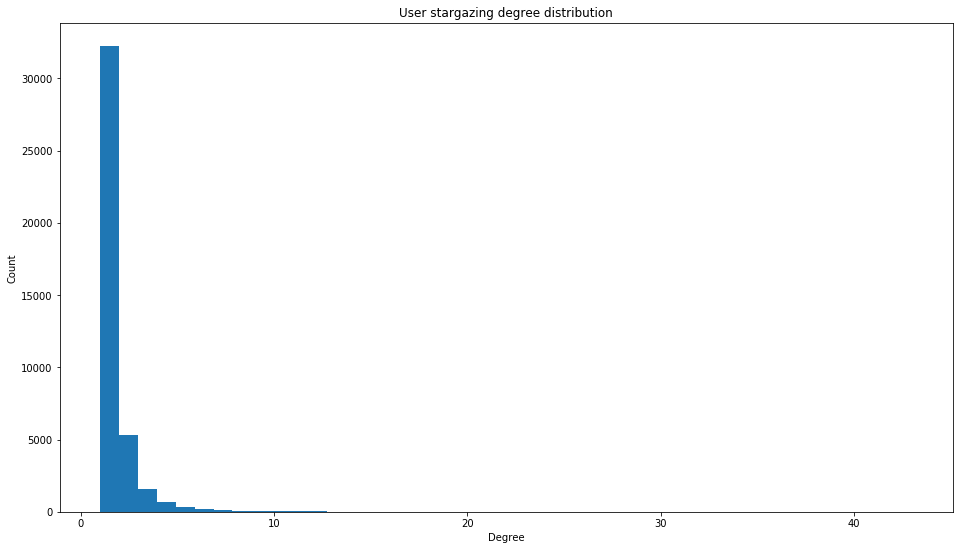

Top stargazers:
followtheart: 43 followings
aki0kaname: 40 followings
CryptoList: 38 followings
soliury: 32 followings
21xhipster: 27 followings


In [19]:
# Out-degree of users
users_out = Stargaze_Network.out_degree(users)

users_deg = [d[1] for d in users_out]

# Mean stargazing degree
print("Mean stargazing degree:", np.mean(users_deg))

# Plot stargazing distribution
fig = plt.figure(figsize=(16,9))
plt.hist(users_deg, bins=max(users_deg))
plt.title("User stargazing degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Top stargazers:
top_stargazers = sorted(users_out, key=lambda x: x[1], reverse=True)[:5]
print("Top stargazers:")
for x in top_stargazers:
    print(str(x[0])+": "+str(x[1])+ " followings")

Most users follow only one currency, but some follow more than one, resulting in a power-law distribution. Users are on average subscribed to 1.4 currencies. The maximum number of currencies stargazed is 43 ("followtheart").

Next, we do the same for the in-degree of the currencies:

Mean currency degree: 147.164102564
Median currency degree: 6.0


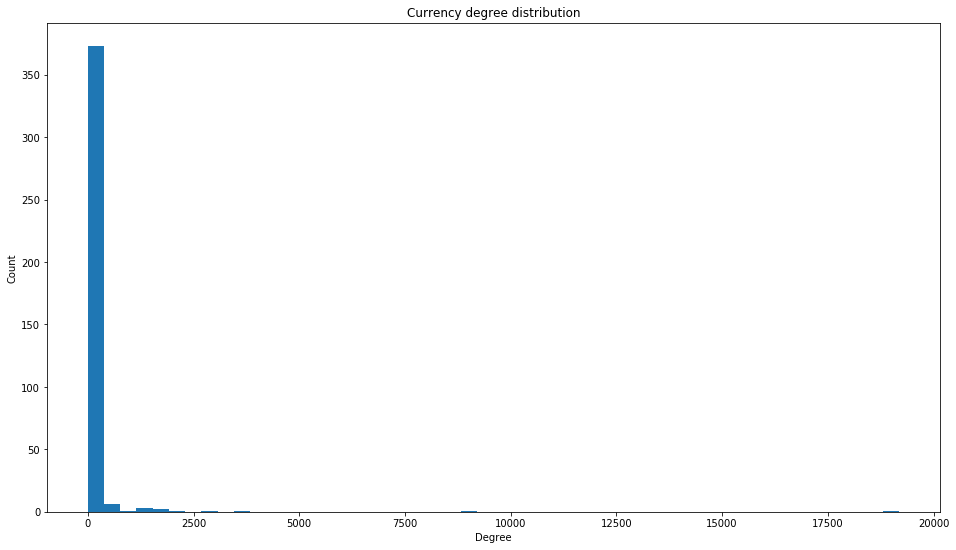

Top currencies:
bitcoin: 19193 followings
ethereum: 8883 followings
lbry-credits: 3549 followings
zcash: 2980 followings
litecoin: 1932 followings


In [25]:
# In-degrees of currencies
curr_in = Stargaze_Network.in_degree(currencies)

# Degrees only
curr_deg = [d[1] for d in curr_in]

# Mean currency degree
print("Mean currency degree:", np.mean(curr_deg))
print("Median currency degree:", np.median(curr_deg))

# Make Histogram
fig = plt.figure(figsize=(16,9))
plt.hist(curr_deg, bins=50)
plt.title("Currency degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Top currencies:
top_currencies = sorted(curr_in, key=lambda x: x[1], reverse=True)[:5]
print("Top currencies:")
for x in top_currencies:
    print(str(x[0])+": "+str(x[1])+ " followings")

For currencies, we have an even steeper power-law distribution of degrees. Most currencies have only very few stargazers, while only a few eclipse the 1000 stargazers mark. Unsurprisingly, bitcoin takes the cake with nearly 20000 stargazers, followed by the second most popular currency, ethereum. On average, a currency has about 147 stargazers. This is influenced heavily by the big currencies though (The median is at only 6 subscribers).

After this first analysis, we can dig deeper into certain aspects of the cryptocurrency github commumnity:

# 3. The analysis

## 3.1 Follower similarity

### 3.1.1 Goals

We want to take a closer look at the follower communities of the individual currencies and find out how similar they are to each other, e.g. see for a pair of cryptocurrencies, how many people have stargazed both of them. Then we can look at how these similarities behave and see whether there are some patterns or not.

### 3.1.2 Step 1: For all CC pairs, create a dictionary of followers

First, we need some preparation done. We need all possible combinations of two currencies, and the users that stargaze both repositories. For N cryptocurrencies, we will get a total of $${{N}\choose{2}}={{390}\choose{2}}=75855$$

In [30]:
# Get pairs
cc_pairs = list(it.combinations(currencies, 2))

print("Total number of pairs:", len(cc_pairs))

# Get cmmon stargazers for both repos
common_user_dict = {}

for pair in cc_pairs:
    users_1 = set([x.login for x in crypto_stargazers_dict[pair[0]]])
    users_2 = set([x.login for x in crypto_stargazers_dict[pair[1]]])
    common_stars = list(users_1 & users_2)
    common_user_dict[pair] = common_stars



Total number of pairs: 75855


In [31]:
# example
print(common_user_dict[('bitcoin-cash', 'ripple')])

['neep3r', 'bobofzhang', '21xhipster', 'epsilonmachine', 'keepfit', 'RedTea', 'fly51fly', 'kipbits', 'danimal141', 'hawkinggg', 'OliverRen', 'avinashkoyyana', 'gty198', 'sbusso', 'srw', 'ksred', 'sysbot', 'nptdat', 'sbedell', 'feihuiwu123', 'samholt', 'jhonsu01', 'millette', 'honve', 'arden', 'followtheart']


There is not much to analyze yet. For this, we first need to define a metric to describe the similarity of two stargazer lists.

### 3.1.3 Step 2: Define a similarity between two user lists

We need to set how we want do define the similarity of two user groups. The most sound way to do this is via the [Jaccard similarity measure](https://en.wikipedia.org/wiki/Jaccard_index). It measures which fraction of elements in the union of two sets is in their intersection:

$$J(A,B) = \frac{|A\cap B|}{|A\cup B|}$$

For our application, this is equivalent to the fraction of users starring at least one of the repositories that have starred both repositories.
We will now define a function that calculates this exact similarity:

In [32]:
def jaccard_currencies(pair):
    # Names of the currencies
    c1=pair[0]
    c2=pair[1]
    
    # Number of individual stargazers
    n1=len(set([x.login for x in crypto_stargazers_dict[c1]]))
    n2=len(set([x.login for x in crypto_stargazers_dict[c2]]))
    # Number of common stargazers
    n12=len(common_user_dict[pair])
    
    # Calculate similarity
    try:
        J=n12/(n1+n2-n12)
    # Catch denominator = 0
    except:
        if n12==0:
            J=0
        else:
            J=1
    return(J)

Now we can calculate this:

In [70]:
# Calculate similarity
cc_similarity={}
for pair in cc_pairs:
    cc_similarity[pair]=jaccard_currencies(pair)
    
# example
print(cc_similarity[('bitcoin', 'ethereum')])

# mean
print(np.mean(list(cc_similarity.values())))

0.09223886403423459
0.00153690720427


To get a first idea, we can now list the top and bottom similarities:

In [44]:
# Top similarities
top_sims = sorted(cc_similarity, key=cc_similarity.get, reverse=True)[:5]
print("Highest similarities:")

for x in top_sims:
    print(str(x)+": Similarity "+str(cc_similarity[(x[0], x[1])]))
    
print("")
# Flop similarities
flop_sims = sorted(cc_similarity, key=cc_similarity.get)[:5]
print("Lowest similarities:")

for x in flop_sims:
    print(str(x)+": Similarity "+str(cc_similarity[(x[0], x[1])]))

Highest similarities:
('steem', 'steem-dollars'): Similarity 1.0
('nav-coin', 'bitdeal'): Similarity 1.0
('e-dinar-coin', 'edrcoin'): Similarity 1.0
('breakout-stake', 'breakout'): Similarity 1.0
('ultracoin', 'incakoin'): Similarity 1.0

Lowest similarities:
('bitcoin', 'nolimitcoin'): Similarity 0.0
('bitcoin', 'leocoin'): Similarity 0.0
('bitcoin', 'einsteinium'): Similarity 0.0
('bitcoin', 'toacoin'): Similarity 0.0
('bitcoin', 'salus'): Similarity 0.0


There are many pairs with similarity 0 or 1, we will investigate these now.

### 3.1.4 Step 3: Analysis of one similarity entries

Here, we take a look at the currency pairs that have identical following bases, e.g. a similarity of 1. Because these ar not that many, we simply list all of them with their stargazer counts and then look at them one by one.

In [47]:
cc_similarity_one = dict((k, v) for k, v in cc_similarity.items() if v == 1)

for key, value in cc_similarity_one.items():
    cc_similarity_one[key]=(len(crypto_stargazers_dict[key[0]]), len(crypto_stargazers_dict[key[1]]))
    print(key[0]+": "+str(len(crypto_stargazers_dict[key[0]]))+ " - "+key[1]+ ": "+str(len(crypto_stargazers_dict[key[1]])))


steem: 648 - steem-dollars: 648
nav-coin: 26 - bitdeal: 26
e-dinar-coin: 5 - edrcoin: 5
breakout-stake: 5 - breakout: 5
ultracoin: 1 - incakoin: 1
zurcoin: 1 - argentum: 1
cypher: 1 - spacecoin: 1
1337: 4 - falcoin: 4
britcoin: 1 - ratecoin: 1
virtacoinplus: 73 - virtacoin: 73


We may disregard repositories with only one stargazer. These have no informative value.
The others are pretty self-explanatory: Currencies with similar names (e.g. [steem](https://github.com/steemit/steem), [steem-dollars](https://github.com/steemit/steem)) simply share the same github repository thus have the same stargazers.

### 3.1.5 Step 4: Analysis of zero similarity entries

Now we will take a look at the pairs with no similarity. First, we again list them with their follower counts.

In [52]:
# Get zero similarity entries
cc_similarity_zero = dict((k, v) for k, v in cc_similarity.items() if v == 0)

# Output
for key, value in cc_similarity_zero.items():
    print(key[0]+": "+str(len(crypto_stargazers_dict[key[0]]))+ " - "+key[1]+ ": "+str(len(crypto_stargazers_dict[key[1]])))

bitcoin: 19193 - nolimitcoin: 3
bitcoin: 19193 - leocoin: 2
bitcoin: 19193 - einsteinium: 1
bitcoin: 19193 - toacoin: 2
bitcoin: 19193 - salus: 1
bitcoin: 19193 - whitecoin: 3
bitcoin: 19193 - abjcoin: 3
bitcoin: 19193 - masternodecoin: 2
bitcoin: 19193 - heat: 8
bitcoin: 19193 - bitbean: 3
bitcoin: 19193 - earthcoin: 9
bitcoin: 19193 - yocoin: 0
bitcoin: 19193 - evergreencoin: 6
bitcoin: 19193 - hush: 1
bitcoin: 19193 - terracoin: 0
bitcoin: 19193 - trustplus: 12
bitcoin: 19193 - karbowanec: 5
bitcoin: 19193 - bluecoin: 0
bitcoin: 19193 - quark: 0
bitcoin: 19193 - parkbyte: 0
bitcoin: 19193 - dopecoin: 0
bitcoin: 19193 - huntercoin: 0
bitcoin: 19193 - visio: 1
bitcoin: 19193 - woodcoin: 2
bitcoin: 19193 - luckchain: 5
bitcoin: 19193 - renos: 6
bitcoin: 19193 - signatum: 13
bitcoin: 19193 - adzcoin: 1
bitcoin: 19193 - influxcoin: 0
bitcoin: 19193 - cryptocarbon: 0
bitcoin: 19193 - ultracoin: 1
bitcoin: 19193 - insanecoin: 4
bitcoin: 19193 - unbreakablecoin: 0
bitcoin: 19193 - teslacoin

dash: 665 - transfercoin: 7
dash: 665 - centurion: 5
dash: 665 - abjcoin: 3
dash: 665 - lomocoin: 13
dash: 665 - htmlcoin: 16
dash: 665 - mooncoin: 14
dash: 665 - gambit: 134
dash: 665 - bitcoin-plus: 5
dash: 665 - e-dinar-coin: 5
dash: 665 - pinkcoin: 2
dash: 665 - heat: 8
dash: 665 - bitbean: 3
dash: 665 - casinocoin: 8
dash: 665 - posw-coin: 8
dash: 665 - exclusivecoin: 7
dash: 665 - pesetacoin: 2
dash: 665 - earthcoin: 9
dash: 665 - yocoin: 0
dash: 665 - blitzcash: 19
dash: 665 - evergreencoin: 6
dash: 665 - hush: 1
dash: 665 - veriumreserve: 14
dash: 665 - terracoin: 0
dash: 665 - zeitcoin: 6
dash: 665 - trustplus: 12
dash: 665 - geocoin: 3
dash: 665 - memetic: 12
dash: 665 - breakout-stake: 5
dash: 665 - bridgecoin: 4
dash: 665 - 2give: 5
dash: 665 - sexcoin: 9
dash: 665 - karbowanec: 5
dash: 665 - bluecoin: 0
dash: 665 - breakout: 5
dash: 665 - dnotes: 2
dash: 665 - quark: 0
dash: 665 - parkbyte: 0
dash: 665 - crave: 23
dash: 665 - dopecoin: 0
dash: 665 - huntercoin: 0
dash: 665

hshare: 61 - dubaicoin: 6
hshare: 61 - energycoin: 2
hshare: 61 - salus: 1
hshare: 61 - monetaryunit: 6
hshare: 61 - radium: 5
hshare: 61 - prizm: 6
hshare: 61 - whitecoin: 3
hshare: 61 - florincoin: 18
hshare: 61 - burst: 68
hshare: 61 - transfercoin: 7
hshare: 61 - centurion: 5
hshare: 61 - abjcoin: 3
hshare: 61 - lomocoin: 13
hshare: 61 - spectrecoin: 21
hshare: 61 - htmlcoin: 16
hshare: 61 - mooncoin: 14
hshare: 61 - unobtanium: 10
hshare: 61 - masternodecoin: 2
hshare: 61 - gambit: 134
hshare: 61 - bitcoin-plus: 5
hshare: 61 - e-dinar-coin: 5
hshare: 61 - pinkcoin: 2
hshare: 61 - heat: 8
hshare: 61 - bitbean: 3
hshare: 61 - xtrabytes: 23
hshare: 61 - stealthcoin: 12
hshare: 61 - casinocoin: 8
hshare: 61 - dynamic: 12
hshare: 61 - curecoin: 38
hshare: 61 - goldcoin: 13
hshare: 61 - sequence: 10
hshare: 61 - musicoin: 76
hshare: 61 - auroracoin: 66
hshare: 61 - posw-coin: 8
hshare: 61 - rupee: 9
hshare: 61 - exclusivecoin: 7
hshare: 61 - pesetacoin: 2
hshare: 61 - synergy: 21
hshare

steem: 648 - namocoin: 0
steem: 648 - protean: 1
steem: 648 - avoncoin: 0
steem: 648 - runners: 0
steem: 648 - moneta: 0
steem: 648 - cyder: 1
steem: 648 - utacoin: 0
steem: 648 - lepen: 1
steem: 648 - sakuracoin: 5
steem: 648 - sync: 0
steem: 648 - bitcedi: 0
steem: 648 - tyrocoin: 0
steem: 648 - goldmaxcoin: 0
steem: 648 - royalties: 1
steem: 648 - hyper: 5
steem: 648 - kashhcoin: 0
steem: 648 - magnetcoin: 0
steem: 648 - peoplecoin: 1
bitshares: 422 - gamecredits: 8
bitshares: 422 - pura: 6
bitshares: 422 - nolimitcoin: 3
bitshares: 422 - bitbay: 8
bitshares: 422 - okcash: 154
bitshares: 422 - groestlcoin: 6
bitshares: 422 - rise: 2
bitshares: 422 - bitcore: 12
bitshares: 422 - potcoin: 15
bitshares: 422 - einsteinium: 1
bitshares: 422 - diamond: 5
bitshares: 422 - minexcoin: 7
bitshares: 422 - solarcoin: 19
bitshares: 422 - toacoin: 2
bitshares: 422 - shift: 11
bitshares: 422 - dubaicoin: 6
bitshares: 422 - energycoin: 2
bitshares: 422 - salus: 1
bitshares: 422 - monetaryunit: 6
bi

pivx: 140 - goldmaxcoin: 0
pivx: 140 - edrcoin: 5
pivx: 140 - royalties: 1
pivx: 140 - kashhcoin: 0
pivx: 140 - magnetcoin: 0
pivx: 140 - peoplecoin: 1
monacoin: 111 - syscoin: 40
monacoin: 111 - lykke: 12
monacoin: 111 - gxshares: 35
monacoin: 111 - pura: 6
monacoin: 111 - particl: 37
monacoin: 111 - zencash: 60
monacoin: 111 - nexus: 45
monacoin: 111 - ubiq: 40
monacoin: 111 - nolimitcoin: 3
monacoin: 111 - okcash: 154
monacoin: 111 - groestlcoin: 6
monacoin: 111 - viacoin: 32
monacoin: 111 - achain: 39
monacoin: 111 - cloakcoin: 8
monacoin: 111 - rise: 2
monacoin: 111 - bitcore: 12
monacoin: 111 - emercoin: 2
monacoin: 111 - leocoin: 2
monacoin: 111 - skycoin: 225
monacoin: 111 - aeon: 122
monacoin: 111 - einsteinium: 1
monacoin: 111 - diamond: 5
monacoin: 111 - namecoin: 215
monacoin: 111 - sibcoin: 15
monacoin: 111 - minexcoin: 7
monacoin: 111 - ion: 7
monacoin: 111 - smartcash: 11
monacoin: 111 - expanse: 26
monacoin: 111 - toacoin: 2
monacoin: 111 - vericoin: 66
monacoin: 111 - 

gamecredits: 8 - daxxcoin: 2
gamecredits: 8 - noblecoin: 2
gamecredits: 8 - smartcoin: 0
gamecredits: 8 - eternity: 9
gamecredits: 8 - electra: 2
gamecredits: 8 - joincoin: 0
gamecredits: 8 - bitcoin-scrypt: 1
gamecredits: 8 - truckcoin: 0
gamecredits: 8 - piggycoin: 6
gamecredits: 8 - opal: 6
gamecredits: 8 - purevidz: 1
gamecredits: 8 - titcoin: 7
gamecredits: 8 - hodlcoin: 16
gamecredits: 8 - the-cypherfunks: 7
gamecredits: 8 - shilling: 3
gamecredits: 8 - grantcoin: 3
gamecredits: 8 - bunnycoin: 0
gamecredits: 8 - digicube: 0
gamecredits: 8 - kushcoin: 1
gamecredits: 8 - biblepay: 6
gamecredits: 8 - digitalcoin: 17
gamecredits: 8 - ratecoin: 1
gamecredits: 8 - revolvercoin: 1
gamecredits: 8 - paycoin: 41
gamecredits: 8 - crypto: 3
gamecredits: 8 - quazarcoin: 4
gamecredits: 8 - swing: 0
gamecredits: 8 - mojocoin: 0
gamecredits: 8 - tittiecoin: 6
gamecredits: 8 - virtualcoin: 0
gamecredits: 8 - bottlecaps: 7
gamecredits: 8 - droxne: 3
gamecredits: 8 - octocoin: 0
gamecredits: 8 - sa

zcoin: 173 - fimkrypto: 5
zcoin: 173 - visio: 1
zcoin: 173 - worldcoin: 4
zcoin: 173 - woodcoin: 2
zcoin: 173 - magi: 17
zcoin: 173 - arcticcoin: 11
zcoin: 173 - dotcoin: 3
zcoin: 173 - pirl: 4
zcoin: 173 - espers: 11
zcoin: 173 - renos: 6
zcoin: 173 - trezarcoin: 11
zcoin: 173 - bitcoinz: 18
zcoin: 173 - unitus: 4
zcoin: 173 - signatum: 13
zcoin: 173 - adzcoin: 1
zcoin: 173 - influxcoin: 0
zcoin: 173 - fastcoin: 19
zcoin: 173 - cryptocarbon: 0
zcoin: 173 - ultracoin: 1
zcoin: 173 - machinecoin: 1
zcoin: 173 - insanecoin: 4
zcoin: 173 - bitradio: 26
zcoin: 173 - monacocoin: 3
zcoin: 173 - sumokoin: 31
zcoin: 173 - fantomcoin: 8
zcoin: 173 - unbreakablecoin: 0
zcoin: 173 - zetacoin: 28
zcoin: 173 - teslacoin: 1
zcoin: 173 - bata: 4
zcoin: 173 - torcoin: 12
zcoin: 173 - netcoin: 7
zcoin: 173 - linda: 13
zcoin: 173 - phoenixcoin: 20
zcoin: 173 - ellaism: 2
zcoin: 173 - sprouts: 2
zcoin: 173 - triangles: 2
zcoin: 173 - digitalprice: 1
zcoin: 173 - pakcoin: 5
zcoin: 173 - vsync: 2
zcoin: 17

bitdeal: 26 - bitstar: 3
bitdeal: 26 - hobonickels: 8
bitdeal: 26 - bitbar: 14
bitdeal: 26 - maxcoin: 64
bitdeal: 26 - orbitcoin: 3
bitdeal: 26 - britcoin: 1
bitdeal: 26 - trollcoin: 2
bitdeal: 26 - swagbucks: 0
bitdeal: 26 - ambercoin: 0
bitdeal: 26 - mazacoin: 21
bitdeal: 26 - gaia: 1
bitdeal: 26 - sterlingcoin: 0
bitdeal: 26 - fuelcoin: 0
bitdeal: 26 - daxxcoin: 2
bitdeal: 26 - noblecoin: 2
bitdeal: 26 - smartcoin: 0
bitdeal: 26 - eternity: 9
bitdeal: 26 - electra: 2
bitdeal: 26 - joincoin: 0
bitdeal: 26 - bitcoin-scrypt: 1
bitdeal: 26 - truckcoin: 0
bitdeal: 26 - piggycoin: 6
bitdeal: 26 - opal: 6
bitdeal: 26 - purevidz: 1
bitdeal: 26 - titcoin: 7
bitdeal: 26 - hodlcoin: 16
bitdeal: 26 - the-cypherfunks: 7
bitdeal: 26 - shilling: 3
bitdeal: 26 - grantcoin: 3
bitdeal: 26 - bunnycoin: 0
bitdeal: 26 - digicube: 0
bitdeal: 26 - kushcoin: 1
bitdeal: 26 - biblepay: 6
bitdeal: 26 - digitalcoin: 17
bitdeal: 26 - ratecoin: 1
bitdeal: 26 - revolvercoin: 1
bitdeal: 26 - paycoin: 41
bitdeal: 2

okcash: 154 - biblepay: 6
okcash: 154 - digitalcoin: 17
okcash: 154 - ratecoin: 1
okcash: 154 - revolvercoin: 1
okcash: 154 - paycoin: 41
okcash: 154 - crypto: 3
okcash: 154 - quazarcoin: 4
okcash: 154 - swing: 0
okcash: 154 - mojocoin: 0
okcash: 154 - tittiecoin: 6
okcash: 154 - virtualcoin: 0
okcash: 154 - bottlecaps: 7
okcash: 154 - droxne: 3
okcash: 154 - octocoin: 0
okcash: 154 - sativacoin: 0
okcash: 154 - spacecoin: 1
okcash: 154 - quatloo: 4
okcash: 154 - wmcoin: 0
okcash: 154 - goldpieces: 2
okcash: 154 - jobscoin: 1
okcash: 154 - argentum: 1
okcash: 154 - franko: 4
okcash: 154 - globaltoken: 0
okcash: 154 - metal-music-coin: 1
okcash: 154 - virtacoinplus: 73
okcash: 154 - secretcoin: 0
okcash: 154 - rimbit: 0
okcash: 154 - macron: 1
okcash: 154 - hexx: 1
okcash: 154 - benjirolls: 0
okcash: 154 - uro: 4
okcash: 154 - soilcoin: 0
okcash: 154 - playercoin: 0
okcash: 154 - comet: 0
okcash: 154 - pesobit: 4
okcash: 154 - steps: 2
okcash: 154 - slevin: 0
okcash: 154 - zonecoin: 0
o

cloakcoin: 8 - bitgem: 4
cloakcoin: 8 - fluttercoin: 6
cloakcoin: 8 - acoin: 3
cloakcoin: 8 - cannacoin: 9
cloakcoin: 8 - theresa-may-coin: 0
cloakcoin: 8 - zurcoin: 1
cloakcoin: 8 - cryptojacks: 0
cloakcoin: 8 - goldblocks: 3
cloakcoin: 8 - blakecoin: 6
cloakcoin: 8 - campuscoin: 0
cloakcoin: 8 - catcoin: 3
cloakcoin: 8 - usde: 6
cloakcoin: 8 - roofs: 0
cloakcoin: 8 - cypher: 1
cloakcoin: 8 - boostcoin: 2
cloakcoin: 8 - master-swiscoin: 3
cloakcoin: 8 - solarflarecoin: 1
cloakcoin: 8 - crevacoin: 1
cloakcoin: 8 - geertcoin: 0
cloakcoin: 8 - grimcoin: 3
cloakcoin: 8 - litebitcoin: 0
cloakcoin: 8 - 1337: 4
cloakcoin: 8 - falcoin: 4
cloakcoin: 8 - yashcoin: 0
cloakcoin: 8 - asiacoin: 0
cloakcoin: 8 - martexcoin: 13
cloakcoin: 8 - infinitecoin: 22
cloakcoin: 8 - cryptcoin: 1
cloakcoin: 8 - incakoin: 1
cloakcoin: 8 - hitcoin: 0
cloakcoin: 8 - anoncoin: 3
cloakcoin: 8 - pandacoin: 7
cloakcoin: 8 - canada-ecoin: 0
cloakcoin: 8 - bitstar: 3
cloakcoin: 8 - hobonickels: 8
cloakcoin: 8 - bitbar:

lbry-credits: 3549 - cachecoin: 2
lbry-credits: 3549 - wmcoin: 0
lbry-credits: 3549 - goldpieces: 2
lbry-credits: 3549 - jobscoin: 1
lbry-credits: 3549 - argentum: 1
lbry-credits: 3549 - kurrent: 6
lbry-credits: 3549 - franko: 4
lbry-credits: 3549 - globaltoken: 0
lbry-credits: 3549 - metal-music-coin: 1
lbry-credits: 3549 - virtacoinplus: 73
lbry-credits: 3549 - secretcoin: 0
lbry-credits: 3549 - rimbit: 0
lbry-credits: 3549 - macron: 1
lbry-credits: 3549 - hexx: 1
lbry-credits: 3549 - benjirolls: 0
lbry-credits: 3549 - uro: 4
lbry-credits: 3549 - soilcoin: 0
lbry-credits: 3549 - playercoin: 0
lbry-credits: 3549 - comet: 0
lbry-credits: 3549 - pesobit: 4
lbry-credits: 3549 - steps: 2
lbry-credits: 3549 - slevin: 0
lbry-credits: 3549 - zonecoin: 0
lbry-credits: 3549 - kronecoin: 0
lbry-credits: 3549 - wexcoin: 0
lbry-credits: 3549 - rsgpcoin: 0
lbry-credits: 3549 - frazcoin: 1
lbry-credits: 3549 - virtacoin: 73
lbry-credits: 3549 - bigboobscoin: 0
lbry-credits: 3549 - mantracoin: 0
lbr

minexcoin: 7 - bigboobscoin: 0
minexcoin: 7 - mantracoin: 0
minexcoin: 7 - geysercoin: 2
minexcoin: 7 - ulatech: 0
minexcoin: 7 - applecoin: 0
minexcoin: 7 - bitcoin-gold: 367
minexcoin: 7 - clubcoin: 3
minexcoin: 7 - phore: 0
minexcoin: 7 - boscoin: 48
minexcoin: 7 - desire: 3
minexcoin: 7 - gulfcoin: 0
minexcoin: 7 - terranova: 1
minexcoin: 7 - bitbase: 0
minexcoin: 7 - vulcano: 0
minexcoin: 7 - buzzcoin: 0
minexcoin: 7 - vpncoin: 16
minexcoin: 7 - paccoin: 2
minexcoin: 7 - force: 2
minexcoin: 7 - dfscoin: 1
minexcoin: 7 - starcash-network: 0
minexcoin: 7 - flash: 0
minexcoin: 7 - stronghands: 0
minexcoin: 7 - amsterdamcoin: 0
minexcoin: 7 - adcoin: 10
minexcoin: 7 - namocoin: 0
minexcoin: 7 - protean: 1
minexcoin: 7 - avoncoin: 0
minexcoin: 7 - runners: 0
minexcoin: 7 - moneta: 0
minexcoin: 7 - qora: 35
minexcoin: 7 - cyder: 1
minexcoin: 7 - utacoin: 0
minexcoin: 7 - lepen: 1
minexcoin: 7 - sakuracoin: 5
minexcoin: 7 - sync: 0
minexcoin: 7 - bitcedi: 0
minexcoin: 7 - tyrocoin: 0
min

toacoin: 2 - paccoin: 2
toacoin: 2 - force: 2
toacoin: 2 - dfscoin: 1
toacoin: 2 - starcash-network: 0
toacoin: 2 - flash: 0
toacoin: 2 - stronghands: 0
toacoin: 2 - amsterdamcoin: 0
toacoin: 2 - adcoin: 10
toacoin: 2 - namocoin: 0
toacoin: 2 - protean: 1
toacoin: 2 - avoncoin: 0
toacoin: 2 - runners: 0
toacoin: 2 - moneta: 0
toacoin: 2 - qora: 35
toacoin: 2 - cyder: 1
toacoin: 2 - utacoin: 0
toacoin: 2 - lepen: 1
toacoin: 2 - sakuracoin: 5
toacoin: 2 - sync: 0
toacoin: 2 - bitcedi: 0
toacoin: 2 - tyrocoin: 0
toacoin: 2 - goldmaxcoin: 0
toacoin: 2 - edrcoin: 5
toacoin: 2 - royalties: 1
toacoin: 2 - hyper: 5
toacoin: 2 - kashhcoin: 0
toacoin: 2 - magnetcoin: 0
toacoin: 2 - peoplecoin: 1
bitsend: 19 - vericoin: 66
bitsend: 19 - blackcoin: 40
bitsend: 19 - digitalnote: 31
bitsend: 19 - golos: 48
bitsend: 19 - omni: 66
bitsend: 19 - shift: 11
bitsend: 19 - clams: 47
bitsend: 19 - dubaicoin: 6
bitsend: 19 - energycoin: 2
bitsend: 19 - salus: 1
bitsend: 19 - monetaryunit: 6
bitsend: 19 - rad

omni: 66 - yashcoin: 0
omni: 66 - asiacoin: 0
omni: 66 - infinitecoin: 22
omni: 66 - cryptcoin: 1
omni: 66 - incakoin: 1
omni: 66 - hitcoin: 0
omni: 66 - anoncoin: 3
omni: 66 - pandacoin: 7
omni: 66 - canada-ecoin: 0
omni: 66 - bitstar: 3
omni: 66 - hobonickels: 8
omni: 66 - bitbar: 14
omni: 66 - orbitcoin: 3
omni: 66 - britcoin: 1
omni: 66 - trollcoin: 2
omni: 66 - swagbucks: 0
omni: 66 - ambercoin: 0
omni: 66 - gaia: 1
omni: 66 - sterlingcoin: 0
omni: 66 - fuelcoin: 0
omni: 66 - daxxcoin: 2
omni: 66 - noblecoin: 2
omni: 66 - smartcoin: 0
omni: 66 - eternity: 9
omni: 66 - electra: 2
omni: 66 - joincoin: 0
omni: 66 - bitcoin-scrypt: 1
omni: 66 - truckcoin: 0
omni: 66 - opal: 6
omni: 66 - purevidz: 1
omni: 66 - titcoin: 7
omni: 66 - hodlcoin: 16
omni: 66 - the-cypherfunks: 7
omni: 66 - shilling: 3
omni: 66 - grantcoin: 3
omni: 66 - bunnycoin: 0
omni: 66 - digicube: 0
omni: 66 - kushcoin: 1
omni: 66 - biblepay: 6
omni: 66 - ratecoin: 1
omni: 66 - revolvercoin: 1
omni: 66 - paycoin: 41
om

asch: 187 - luckchain: 5
asch: 187 - arcticcoin: 11
asch: 187 - dotcoin: 3
asch: 187 - pirl: 4
asch: 187 - espers: 11
asch: 187 - cryptonite: 20
asch: 187 - renos: 6
asch: 187 - trezarcoin: 11
asch: 187 - bitcoinz: 18
asch: 187 - unitus: 4
asch: 187 - signatum: 13
asch: 187 - adzcoin: 1
asch: 187 - influxcoin: 0
asch: 187 - bitzeny: 13
asch: 187 - fastcoin: 19
asch: 187 - cryptocarbon: 0
asch: 187 - ultracoin: 1
asch: 187 - machinecoin: 1
asch: 187 - insanecoin: 4
asch: 187 - bitradio: 26
asch: 187 - monacocoin: 3
asch: 187 - sumokoin: 31
asch: 187 - fantomcoin: 8
asch: 187 - capricoin: 3
asch: 187 - unbreakablecoin: 0
asch: 187 - zetacoin: 28
asch: 187 - teslacoin: 1
asch: 187 - bata: 4
asch: 187 - torcoin: 12
asch: 187 - netcoin: 7
asch: 187 - denarius: 20
asch: 187 - linda: 13
asch: 187 - luxcoin: 7
asch: 187 - phoenixcoin: 20
asch: 187 - ellaism: 2
asch: 187 - sprouts: 2
asch: 187 - triangles: 2
asch: 187 - digitalprice: 1
asch: 187 - pakcoin: 5
asch: 187 - deutsche-emark: 5
asch: 

centurion: 5 - avoncoin: 0
centurion: 5 - runners: 0
centurion: 5 - moneta: 0
centurion: 5 - qora: 35
centurion: 5 - cyder: 1
centurion: 5 - utacoin: 0
centurion: 5 - lepen: 1
centurion: 5 - sakuracoin: 5
centurion: 5 - sync: 0
centurion: 5 - bitcedi: 0
centurion: 5 - tyrocoin: 0
centurion: 5 - goldmaxcoin: 0
centurion: 5 - edrcoin: 5
centurion: 5 - royalties: 1
centurion: 5 - hyper: 5
centurion: 5 - kashhcoin: 0
centurion: 5 - magnetcoin: 0
centurion: 5 - peoplecoin: 1
novacoin: 55 - abjcoin: 3
novacoin: 55 - lomocoin: 13
novacoin: 55 - spectrecoin: 21
novacoin: 55 - htmlcoin: 16
novacoin: 55 - mooncoin: 14
novacoin: 55 - masternodecoin: 2
novacoin: 55 - gambit: 134
novacoin: 55 - bitcoin-plus: 5
novacoin: 55 - e-dinar-coin: 5
novacoin: 55 - pinkcoin: 2
novacoin: 55 - heat: 8
novacoin: 55 - bitbean: 3
novacoin: 55 - xtrabytes: 23
novacoin: 55 - casinocoin: 8
novacoin: 55 - dynamic: 12
novacoin: 55 - sequence: 10
novacoin: 55 - musicoin: 76
novacoin: 55 - posw-coin: 8
novacoin: 55 - ru

masternodecoin: 2 - infinitecoin: 22
masternodecoin: 2 - cryptcoin: 1
masternodecoin: 2 - incakoin: 1
masternodecoin: 2 - hitcoin: 0
masternodecoin: 2 - anoncoin: 3
masternodecoin: 2 - pandacoin: 7
masternodecoin: 2 - shadowcash: 89
masternodecoin: 2 - canada-ecoin: 0
masternodecoin: 2 - bitstar: 3
masternodecoin: 2 - hobonickels: 8
masternodecoin: 2 - bitbar: 14
masternodecoin: 2 - maxcoin: 64
masternodecoin: 2 - orbitcoin: 3
masternodecoin: 2 - britcoin: 1
masternodecoin: 2 - trollcoin: 2
masternodecoin: 2 - swagbucks: 0
masternodecoin: 2 - ambercoin: 0
masternodecoin: 2 - mazacoin: 21
masternodecoin: 2 - gaia: 1
masternodecoin: 2 - sterlingcoin: 0
masternodecoin: 2 - fuelcoin: 0
masternodecoin: 2 - daxxcoin: 2
masternodecoin: 2 - noblecoin: 2
masternodecoin: 2 - smartcoin: 0
masternodecoin: 2 - eternity: 9
masternodecoin: 2 - electra: 2
masternodecoin: 2 - joincoin: 0
masternodecoin: 2 - bitcoin-scrypt: 1
masternodecoin: 2 - truckcoin: 0
masternodecoin: 2 - piggycoin: 6
masternodeco

xtrabytes: 23 - ambercoin: 0
xtrabytes: 23 - mazacoin: 21
xtrabytes: 23 - gaia: 1
xtrabytes: 23 - sterlingcoin: 0
xtrabytes: 23 - fuelcoin: 0
xtrabytes: 23 - daxxcoin: 2
xtrabytes: 23 - noblecoin: 2
xtrabytes: 23 - smartcoin: 0
xtrabytes: 23 - eternity: 9
xtrabytes: 23 - electra: 2
xtrabytes: 23 - joincoin: 0
xtrabytes: 23 - bitcoin-scrypt: 1
xtrabytes: 23 - truckcoin: 0
xtrabytes: 23 - piggycoin: 6
xtrabytes: 23 - opal: 6
xtrabytes: 23 - purevidz: 1
xtrabytes: 23 - titcoin: 7
xtrabytes: 23 - the-cypherfunks: 7
xtrabytes: 23 - shilling: 3
xtrabytes: 23 - grantcoin: 3
xtrabytes: 23 - bunnycoin: 0
xtrabytes: 23 - digicube: 0
xtrabytes: 23 - kushcoin: 1
xtrabytes: 23 - biblepay: 6
xtrabytes: 23 - digitalcoin: 17
xtrabytes: 23 - ratecoin: 1
xtrabytes: 23 - revolvercoin: 1
xtrabytes: 23 - paycoin: 41
xtrabytes: 23 - crypto: 3
xtrabytes: 23 - quazarcoin: 4
xtrabytes: 23 - swing: 0
xtrabytes: 23 - mojocoin: 0
xtrabytes: 23 - tittiecoin: 6
xtrabytes: 23 - virtualcoin: 0
xtrabytes: 23 - bottlec

musicoin: 76 - veltor: 0
musicoin: 76 - ethereum-dark: 11
musicoin: 76 - mincoin: 1
musicoin: 76 - embercoin: 2
musicoin: 76 - trumpcoin: 4
musicoin: 76 - joulecoin: 8
musicoin: 76 - nyancoin: 6
musicoin: 76 - bitgem: 4
musicoin: 76 - fluttercoin: 6
musicoin: 76 - acoin: 3
musicoin: 76 - cannacoin: 9
musicoin: 76 - theresa-may-coin: 0
musicoin: 76 - zurcoin: 1
musicoin: 76 - cryptojacks: 0
musicoin: 76 - goldblocks: 3
musicoin: 76 - blakecoin: 6
musicoin: 76 - campuscoin: 0
musicoin: 76 - catcoin: 3
musicoin: 76 - usde: 6
musicoin: 76 - roofs: 0
musicoin: 76 - cypher: 1
musicoin: 76 - boostcoin: 2
musicoin: 76 - master-swiscoin: 3
musicoin: 76 - solarflarecoin: 1
musicoin: 76 - crevacoin: 1
musicoin: 76 - geertcoin: 0
musicoin: 76 - litebitcoin: 0
musicoin: 76 - 1337: 4
musicoin: 76 - falcoin: 4
musicoin: 76 - yashcoin: 0
musicoin: 76 - asiacoin: 0
musicoin: 76 - martexcoin: 13
musicoin: 76 - infinitecoin: 22
musicoin: 76 - cryptcoin: 1
musicoin: 76 - incakoin: 1
musicoin: 76 - hitcoin

chaincoin: 48 - triangles: 2
chaincoin: 48 - digitalprice: 1
chaincoin: 48 - pakcoin: 5
chaincoin: 48 - deutsche-emark: 5
chaincoin: 48 - fujicoin: 3
chaincoin: 48 - vsync: 2
chaincoin: 48 - cagecoin: 1
chaincoin: 48 - veltor: 0
chaincoin: 48 - ethereum-dark: 11
chaincoin: 48 - mincoin: 1
chaincoin: 48 - embercoin: 2
chaincoin: 48 - trumpcoin: 4
chaincoin: 48 - joulecoin: 8
chaincoin: 48 - nyancoin: 6
chaincoin: 48 - fluttercoin: 6
chaincoin: 48 - acoin: 3
chaincoin: 48 - cannacoin: 9
chaincoin: 48 - theresa-may-coin: 0
chaincoin: 48 - zurcoin: 1
chaincoin: 48 - cryptojacks: 0
chaincoin: 48 - goldblocks: 3
chaincoin: 48 - blakecoin: 6
chaincoin: 48 - campuscoin: 0
chaincoin: 48 - catcoin: 3
chaincoin: 48 - usde: 6
chaincoin: 48 - roofs: 0
chaincoin: 48 - cypher: 1
chaincoin: 48 - boostcoin: 2
chaincoin: 48 - master-swiscoin: 3
chaincoin: 48 - solarflarecoin: 1
chaincoin: 48 - crevacoin: 1
chaincoin: 48 - geertcoin: 0
chaincoin: 48 - grimcoin: 3
chaincoin: 48 - litebitcoin: 0
chaincoin:

veriumreserve: 14 - britcoin: 1
veriumreserve: 14 - trollcoin: 2
veriumreserve: 14 - swagbucks: 0
veriumreserve: 14 - ambercoin: 0
veriumreserve: 14 - gaia: 1
veriumreserve: 14 - sterlingcoin: 0
veriumreserve: 14 - fuelcoin: 0
veriumreserve: 14 - daxxcoin: 2
veriumreserve: 14 - noblecoin: 2
veriumreserve: 14 - smartcoin: 0
veriumreserve: 14 - eternity: 9
veriumreserve: 14 - electra: 2
veriumreserve: 14 - joincoin: 0
veriumreserve: 14 - bitcoin-scrypt: 1
veriumreserve: 14 - truckcoin: 0
veriumreserve: 14 - piggycoin: 6
veriumreserve: 14 - opal: 6
veriumreserve: 14 - purevidz: 1
veriumreserve: 14 - hodlcoin: 16
veriumreserve: 14 - the-cypherfunks: 7
veriumreserve: 14 - shilling: 3
veriumreserve: 14 - grantcoin: 3
veriumreserve: 14 - bunnycoin: 0
veriumreserve: 14 - digicube: 0
veriumreserve: 14 - kushcoin: 1
veriumreserve: 14 - biblepay: 6
veriumreserve: 14 - digitalcoin: 17
veriumreserve: 14 - ratecoin: 1
veriumreserve: 14 - revolvercoin: 1
veriumreserve: 14 - paycoin: 41
veriumreserve:

memetic: 12 - revolvercoin: 1
memetic: 12 - paycoin: 41
memetic: 12 - crypto: 3
memetic: 12 - quazarcoin: 4
memetic: 12 - swing: 0
memetic: 12 - mojocoin: 0
memetic: 12 - tittiecoin: 6
memetic: 12 - virtualcoin: 0
memetic: 12 - bottlecaps: 7
memetic: 12 - droxne: 3
memetic: 12 - octocoin: 0
memetic: 12 - sativacoin: 0
memetic: 12 - spacecoin: 1
memetic: 12 - cachecoin: 2
memetic: 12 - quatloo: 4
memetic: 12 - wmcoin: 0
memetic: 12 - goldpieces: 2
memetic: 12 - jobscoin: 1
memetic: 12 - argentum: 1
memetic: 12 - kurrent: 6
memetic: 12 - franko: 4
memetic: 12 - globaltoken: 0
memetic: 12 - metal-music-coin: 1
memetic: 12 - virtacoinplus: 73
memetic: 12 - secretcoin: 0
memetic: 12 - rimbit: 0
memetic: 12 - macron: 1
memetic: 12 - hexx: 1
memetic: 12 - benjirolls: 0
memetic: 12 - uro: 4
memetic: 12 - soilcoin: 0
memetic: 12 - playercoin: 0
memetic: 12 - comet: 0
memetic: 12 - pesobit: 4
memetic: 12 - steps: 2
memetic: 12 - slevin: 0
memetic: 12 - zonecoin: 0
memetic: 12 - kronecoin: 0
meme

2give: 5 - dnotes: 2
2give: 5 - mintcoin: 14
2give: 5 - quark: 0
2give: 5 - innova: 4
2give: 5 - parkbyte: 0
2give: 5 - fedoracoin: 10
2give: 5 - riecoin: 18
2give: 5 - bismuth: 53
2give: 5 - spreadcoin: 8
2give: 5 - crave: 23
2give: 5 - dopecoin: 0
2give: 5 - huntercoin: 0
2give: 5 - fimkrypto: 5
2give: 5 - creativecoin: 16
2give: 5 - visio: 1
2give: 5 - worldcoin: 4
2give: 5 - vtorrent: 21
2give: 5 - cannabiscoin: 17
2give: 5 - woodcoin: 2
2give: 5 - magi: 17
2give: 5 - startcoin: 12
2give: 5 - megacoin: 24
2give: 5 - luckchain: 5
2give: 5 - arcticcoin: 11
2give: 5 - dotcoin: 3
2give: 5 - pirl: 4
2give: 5 - espers: 11
2give: 5 - cryptonite: 20
2give: 5 - renos: 6
2give: 5 - trezarcoin: 11
2give: 5 - bitcoinz: 18
2give: 5 - unitus: 4
2give: 5 - signatum: 13
2give: 5 - adzcoin: 1
2give: 5 - hyperstake: 9
2give: 5 - influxcoin: 0
2give: 5 - bitzeny: 13
2give: 5 - fastcoin: 19
2give: 5 - cryptocarbon: 0
2give: 5 - ultracoin: 1
2give: 5 - machinecoin: 1
2give: 5 - insanecoin: 4
2give: 5 -

innova: 4 - litebitcoin: 0
innova: 4 - 1337: 4
innova: 4 - falcoin: 4
innova: 4 - yashcoin: 0
innova: 4 - asiacoin: 0
innova: 4 - martexcoin: 13
innova: 4 - infinitecoin: 22
innova: 4 - cryptcoin: 1
innova: 4 - incakoin: 1
innova: 4 - hitcoin: 0
innova: 4 - anoncoin: 3
innova: 4 - pandacoin: 7
innova: 4 - shadowcash: 89
innova: 4 - canada-ecoin: 0
innova: 4 - bitstar: 3
innova: 4 - hobonickels: 8
innova: 4 - bitbar: 14
innova: 4 - maxcoin: 64
innova: 4 - orbitcoin: 3
innova: 4 - britcoin: 1
innova: 4 - trollcoin: 2
innova: 4 - swagbucks: 0
innova: 4 - ambercoin: 0
innova: 4 - mazacoin: 21
innova: 4 - gaia: 1
innova: 4 - sterlingcoin: 0
innova: 4 - fuelcoin: 0
innova: 4 - daxxcoin: 2
innova: 4 - noblecoin: 2
innova: 4 - smartcoin: 0
innova: 4 - electra: 2
innova: 4 - joincoin: 0
innova: 4 - bitcoin-scrypt: 1
innova: 4 - truckcoin: 0
innova: 4 - piggycoin: 6
innova: 4 - opal: 6
innova: 4 - purevidz: 1
innova: 4 - titcoin: 7
innova: 4 - hodlcoin: 16
innova: 4 - the-cypherfunks: 7
innova: 

huntercoin: 0 - wexcoin: 0
huntercoin: 0 - rsgpcoin: 0
huntercoin: 0 - frazcoin: 1
huntercoin: 0 - virtacoin: 73
huntercoin: 0 - enigma: 138
huntercoin: 0 - bigboobscoin: 0
huntercoin: 0 - mantracoin: 0
huntercoin: 0 - geysercoin: 2
huntercoin: 0 - ulatech: 0
huntercoin: 0 - applecoin: 0
huntercoin: 0 - bitcoin-gold: 367
huntercoin: 0 - clubcoin: 3
huntercoin: 0 - phore: 0
huntercoin: 0 - boscoin: 48
huntercoin: 0 - desire: 3
huntercoin: 0 - gulfcoin: 0
huntercoin: 0 - terranova: 1
huntercoin: 0 - bitbase: 0
huntercoin: 0 - vulcano: 0
huntercoin: 0 - buzzcoin: 0
huntercoin: 0 - vpncoin: 16
huntercoin: 0 - paccoin: 2
huntercoin: 0 - force: 2
huntercoin: 0 - dfscoin: 1
huntercoin: 0 - starcash-network: 0
huntercoin: 0 - flash: 0
huntercoin: 0 - stronghands: 0
huntercoin: 0 - amsterdamcoin: 0
huntercoin: 0 - adcoin: 10
huntercoin: 0 - namocoin: 0
huntercoin: 0 - protean: 1
huntercoin: 0 - avoncoin: 0
huntercoin: 0 - runners: 0
huntercoin: 0 - moneta: 0
huntercoin: 0 - qora: 35
huntercoin:

luckchain: 5 - cryptojacks: 0
luckchain: 5 - goldblocks: 3
luckchain: 5 - blakecoin: 6
luckchain: 5 - campuscoin: 0
luckchain: 5 - catcoin: 3
luckchain: 5 - usde: 6
luckchain: 5 - roofs: 0
luckchain: 5 - cypher: 1
luckchain: 5 - boostcoin: 2
luckchain: 5 - master-swiscoin: 3
luckchain: 5 - solarflarecoin: 1
luckchain: 5 - crevacoin: 1
luckchain: 5 - geertcoin: 0
luckchain: 5 - grimcoin: 3
luckchain: 5 - litebitcoin: 0
luckchain: 5 - 1337: 4
luckchain: 5 - falcoin: 4
luckchain: 5 - yashcoin: 0
luckchain: 5 - asiacoin: 0
luckchain: 5 - martexcoin: 13
luckchain: 5 - infinitecoin: 22
luckchain: 5 - cryptcoin: 1
luckchain: 5 - incakoin: 1
luckchain: 5 - hitcoin: 0
luckchain: 5 - anoncoin: 3
luckchain: 5 - pandacoin: 7
luckchain: 5 - shadowcash: 89
luckchain: 5 - canada-ecoin: 0
luckchain: 5 - bitstar: 3
luckchain: 5 - hobonickels: 8
luckchain: 5 - bitbar: 14
luckchain: 5 - maxcoin: 64
luckchain: 5 - orbitcoin: 3
luckchain: 5 - britcoin: 1
luckchain: 5 - trollcoin: 2
luckchain: 5 - swagbucks

unitus: 4 - force: 2
unitus: 4 - dfscoin: 1
unitus: 4 - starcash-network: 0
unitus: 4 - flash: 0
unitus: 4 - stronghands: 0
unitus: 4 - amsterdamcoin: 0
unitus: 4 - adcoin: 10
unitus: 4 - namocoin: 0
unitus: 4 - protean: 1
unitus: 4 - avoncoin: 0
unitus: 4 - runners: 0
unitus: 4 - moneta: 0
unitus: 4 - qora: 35
unitus: 4 - cyder: 1
unitus: 4 - utacoin: 0
unitus: 4 - lepen: 1
unitus: 4 - sakuracoin: 5
unitus: 4 - sync: 0
unitus: 4 - bitcedi: 0
unitus: 4 - tyrocoin: 0
unitus: 4 - goldmaxcoin: 0
unitus: 4 - edrcoin: 5
unitus: 4 - royalties: 1
unitus: 4 - hyper: 5
unitus: 4 - kashhcoin: 0
unitus: 4 - magnetcoin: 0
unitus: 4 - peoplecoin: 1
signatum: 13 - adzcoin: 1
signatum: 13 - hyperstake: 9
signatum: 13 - influxcoin: 0
signatum: 13 - bitzeny: 13
signatum: 13 - fastcoin: 19
signatum: 13 - cryptocarbon: 0
signatum: 13 - ultracoin: 1
signatum: 13 - machinecoin: 1
signatum: 13 - insanecoin: 4
signatum: 13 - moin: 3
signatum: 13 - bitradio: 26
signatum: 13 - monacocoin: 3
signatum: 13 - sumo

insanecoin: 4 - electra: 2
insanecoin: 4 - joincoin: 0
insanecoin: 4 - bitcoin-scrypt: 1
insanecoin: 4 - truckcoin: 0
insanecoin: 4 - piggycoin: 6
insanecoin: 4 - opal: 6
insanecoin: 4 - purevidz: 1
insanecoin: 4 - titcoin: 7
insanecoin: 4 - hodlcoin: 16
insanecoin: 4 - the-cypherfunks: 7
insanecoin: 4 - shilling: 3
insanecoin: 4 - grantcoin: 3
insanecoin: 4 - bunnycoin: 0
insanecoin: 4 - digicube: 0
insanecoin: 4 - kushcoin: 1
insanecoin: 4 - biblepay: 6
insanecoin: 4 - digitalcoin: 17
insanecoin: 4 - ratecoin: 1
insanecoin: 4 - revolvercoin: 1
insanecoin: 4 - paycoin: 41
insanecoin: 4 - crypto: 3
insanecoin: 4 - quazarcoin: 4
insanecoin: 4 - swing: 0
insanecoin: 4 - mojocoin: 0
insanecoin: 4 - tittiecoin: 6
insanecoin: 4 - virtualcoin: 0
insanecoin: 4 - bottlecaps: 7
insanecoin: 4 - droxne: 3
insanecoin: 4 - octocoin: 0
insanecoin: 4 - sativacoin: 0
insanecoin: 4 - spacecoin: 1
insanecoin: 4 - cachecoin: 2
insanecoin: 4 - quatloo: 4
insanecoin: 4 - wmcoin: 0
insanecoin: 4 - goldpiece

torcoin: 12 - secretcoin: 0
torcoin: 12 - rimbit: 0
torcoin: 12 - macron: 1
torcoin: 12 - hexx: 1
torcoin: 12 - benjirolls: 0
torcoin: 12 - uro: 4
torcoin: 12 - soilcoin: 0
torcoin: 12 - playercoin: 0
torcoin: 12 - comet: 0
torcoin: 12 - pesobit: 4
torcoin: 12 - steps: 2
torcoin: 12 - slevin: 0
torcoin: 12 - zonecoin: 0
torcoin: 12 - kronecoin: 0
torcoin: 12 - wexcoin: 0
torcoin: 12 - rsgpcoin: 0
torcoin: 12 - frazcoin: 1
torcoin: 12 - virtacoin: 73
torcoin: 12 - enigma: 138
torcoin: 12 - bigboobscoin: 0
torcoin: 12 - mantracoin: 0
torcoin: 12 - geysercoin: 2
torcoin: 12 - ulatech: 0
torcoin: 12 - applecoin: 0
torcoin: 12 - bitcoin-gold: 367
torcoin: 12 - clubcoin: 3
torcoin: 12 - phore: 0
torcoin: 12 - boscoin: 48
torcoin: 12 - desire: 3
torcoin: 12 - gulfcoin: 0
torcoin: 12 - terranova: 1
torcoin: 12 - bitbase: 0
torcoin: 12 - vulcano: 0
torcoin: 12 - buzzcoin: 0
torcoin: 12 - vpncoin: 16
torcoin: 12 - paccoin: 2
torcoin: 12 - force: 2
torcoin: 12 - starcash-network: 0
torcoin: 12 - 

digitalprice: 1 - enigma: 138
digitalprice: 1 - bigboobscoin: 0
digitalprice: 1 - mantracoin: 0
digitalprice: 1 - geysercoin: 2
digitalprice: 1 - ulatech: 0
digitalprice: 1 - applecoin: 0
digitalprice: 1 - bitcoin-gold: 367
digitalprice: 1 - clubcoin: 3
digitalprice: 1 - phore: 0
digitalprice: 1 - boscoin: 48
digitalprice: 1 - desire: 3
digitalprice: 1 - gulfcoin: 0
digitalprice: 1 - terranova: 1
digitalprice: 1 - bitbase: 0
digitalprice: 1 - vulcano: 0
digitalprice: 1 - buzzcoin: 0
digitalprice: 1 - vpncoin: 16
digitalprice: 1 - paccoin: 2
digitalprice: 1 - force: 2
digitalprice: 1 - dfscoin: 1
digitalprice: 1 - starcash-network: 0
digitalprice: 1 - flash: 0
digitalprice: 1 - stronghands: 0
digitalprice: 1 - amsterdamcoin: 0
digitalprice: 1 - adcoin: 10
digitalprice: 1 - namocoin: 0
digitalprice: 1 - protean: 1
digitalprice: 1 - avoncoin: 0
digitalprice: 1 - runners: 0
digitalprice: 1 - moneta: 0
digitalprice: 1 - cyder: 1
digitalprice: 1 - utacoin: 0
digitalprice: 1 - lepen: 1
digita

nyancoin: 6 - soilcoin: 0
nyancoin: 6 - playercoin: 0
nyancoin: 6 - comet: 0
nyancoin: 6 - pesobit: 4
nyancoin: 6 - steps: 2
nyancoin: 6 - slevin: 0
nyancoin: 6 - zonecoin: 0
nyancoin: 6 - kronecoin: 0
nyancoin: 6 - wexcoin: 0
nyancoin: 6 - rsgpcoin: 0
nyancoin: 6 - frazcoin: 1
nyancoin: 6 - virtacoin: 73
nyancoin: 6 - enigma: 138
nyancoin: 6 - bigboobscoin: 0
nyancoin: 6 - mantracoin: 0
nyancoin: 6 - geysercoin: 2
nyancoin: 6 - ulatech: 0
nyancoin: 6 - applecoin: 0
nyancoin: 6 - bitcoin-gold: 367
nyancoin: 6 - clubcoin: 3
nyancoin: 6 - phore: 0
nyancoin: 6 - boscoin: 48
nyancoin: 6 - desire: 3
nyancoin: 6 - gulfcoin: 0
nyancoin: 6 - terranova: 1
nyancoin: 6 - bitbase: 0
nyancoin: 6 - vulcano: 0
nyancoin: 6 - buzzcoin: 0
nyancoin: 6 - vpncoin: 16
nyancoin: 6 - paccoin: 2
nyancoin: 6 - force: 2
nyancoin: 6 - dfscoin: 1
nyancoin: 6 - starcash-network: 0
nyancoin: 6 - flash: 0
nyancoin: 6 - stronghands: 0
nyancoin: 6 - amsterdamcoin: 0
nyancoin: 6 - adcoin: 10
nyancoin: 6 - namocoin: 0
ny

roofs: 0 - boostcoin: 2
roofs: 0 - master-swiscoin: 3
roofs: 0 - solarflarecoin: 1
roofs: 0 - crevacoin: 1
roofs: 0 - geertcoin: 0
roofs: 0 - grimcoin: 3
roofs: 0 - litebitcoin: 0
roofs: 0 - 1337: 4
roofs: 0 - falcoin: 4
roofs: 0 - yashcoin: 0
roofs: 0 - asiacoin: 0
roofs: 0 - martexcoin: 13
roofs: 0 - infinitecoin: 22
roofs: 0 - cryptcoin: 1
roofs: 0 - incakoin: 1
roofs: 0 - hitcoin: 0
roofs: 0 - anoncoin: 3
roofs: 0 - pandacoin: 7
roofs: 0 - shadowcash: 89
roofs: 0 - canada-ecoin: 0
roofs: 0 - bitstar: 3
roofs: 0 - hobonickels: 8
roofs: 0 - bitbar: 14
roofs: 0 - maxcoin: 64
roofs: 0 - orbitcoin: 3
roofs: 0 - britcoin: 1
roofs: 0 - trollcoin: 2
roofs: 0 - swagbucks: 0
roofs: 0 - ambercoin: 0
roofs: 0 - mazacoin: 21
roofs: 0 - gaia: 1
roofs: 0 - sterlingcoin: 0
roofs: 0 - fuelcoin: 0
roofs: 0 - daxxcoin: 2
roofs: 0 - noblecoin: 2
roofs: 0 - smartcoin: 0
roofs: 0 - eternity: 9
roofs: 0 - electra: 2
roofs: 0 - joincoin: 0
roofs: 0 - bitcoin-scrypt: 1
roofs: 0 - truckcoin: 0
roofs: 0 - pi

infinitecoin: 22 - qora: 35
infinitecoin: 22 - cyder: 1
infinitecoin: 22 - utacoin: 0
infinitecoin: 22 - lepen: 1
infinitecoin: 22 - sakuracoin: 5
infinitecoin: 22 - sync: 0
infinitecoin: 22 - bitcedi: 0
infinitecoin: 22 - tyrocoin: 0
infinitecoin: 22 - goldmaxcoin: 0
infinitecoin: 22 - edrcoin: 5
infinitecoin: 22 - royalties: 1
infinitecoin: 22 - hyper: 5
infinitecoin: 22 - kashhcoin: 0
infinitecoin: 22 - magnetcoin: 0
infinitecoin: 22 - peoplecoin: 1
cryptcoin: 1 - incakoin: 1
cryptcoin: 1 - hitcoin: 0
cryptcoin: 1 - anoncoin: 3
cryptcoin: 1 - pandacoin: 7
cryptcoin: 1 - shadowcash: 89
cryptcoin: 1 - canada-ecoin: 0
cryptcoin: 1 - bitstar: 3
cryptcoin: 1 - hobonickels: 8
cryptcoin: 1 - bitbar: 14
cryptcoin: 1 - maxcoin: 64
cryptcoin: 1 - orbitcoin: 3
cryptcoin: 1 - britcoin: 1
cryptcoin: 1 - trollcoin: 2
cryptcoin: 1 - swagbucks: 0
cryptcoin: 1 - ambercoin: 0
cryptcoin: 1 - mazacoin: 21
cryptcoin: 1 - gaia: 1
cryptcoin: 1 - sterlingcoin: 0
cryptcoin: 1 - fuelcoin: 0
cryptcoin: 1 - da

fuelcoin: 0 - metal-music-coin: 1
fuelcoin: 0 - virtacoinplus: 73
fuelcoin: 0 - secretcoin: 0
fuelcoin: 0 - rimbit: 0
fuelcoin: 0 - macron: 1
fuelcoin: 0 - hexx: 1
fuelcoin: 0 - benjirolls: 0
fuelcoin: 0 - uro: 4
fuelcoin: 0 - soilcoin: 0
fuelcoin: 0 - playercoin: 0
fuelcoin: 0 - comet: 0
fuelcoin: 0 - pesobit: 4
fuelcoin: 0 - steps: 2
fuelcoin: 0 - slevin: 0
fuelcoin: 0 - zonecoin: 0
fuelcoin: 0 - kronecoin: 0
fuelcoin: 0 - wexcoin: 0
fuelcoin: 0 - rsgpcoin: 0
fuelcoin: 0 - frazcoin: 1
fuelcoin: 0 - virtacoin: 73
fuelcoin: 0 - enigma: 138
fuelcoin: 0 - bigboobscoin: 0
fuelcoin: 0 - mantracoin: 0
fuelcoin: 0 - geysercoin: 2
fuelcoin: 0 - ulatech: 0
fuelcoin: 0 - applecoin: 0
fuelcoin: 0 - bitcoin-gold: 367
fuelcoin: 0 - clubcoin: 3
fuelcoin: 0 - phore: 0
fuelcoin: 0 - boscoin: 48
fuelcoin: 0 - desire: 3
fuelcoin: 0 - gulfcoin: 0
fuelcoin: 0 - terranova: 1
fuelcoin: 0 - bitbase: 0
fuelcoin: 0 - vulcano: 0
fuelcoin: 0 - buzzcoin: 0
fuelcoin: 0 - vpncoin: 16
fuelcoin: 0 - paccoin: 2
fuelc

shilling: 3 - virtualcoin: 0
shilling: 3 - bottlecaps: 7
shilling: 3 - droxne: 3
shilling: 3 - octocoin: 0
shilling: 3 - sativacoin: 0
shilling: 3 - spacecoin: 1
shilling: 3 - cachecoin: 2
shilling: 3 - quatloo: 4
shilling: 3 - wmcoin: 0
shilling: 3 - goldpieces: 2
shilling: 3 - jobscoin: 1
shilling: 3 - argentum: 1
shilling: 3 - kurrent: 6
shilling: 3 - franko: 4
shilling: 3 - globaltoken: 0
shilling: 3 - metal-music-coin: 1
shilling: 3 - virtacoinplus: 73
shilling: 3 - secretcoin: 0
shilling: 3 - rimbit: 0
shilling: 3 - macron: 1
shilling: 3 - hexx: 1
shilling: 3 - benjirolls: 0
shilling: 3 - uro: 4
shilling: 3 - soilcoin: 0
shilling: 3 - playercoin: 0
shilling: 3 - comet: 0
shilling: 3 - pesobit: 4
shilling: 3 - steps: 2
shilling: 3 - slevin: 0
shilling: 3 - zonecoin: 0
shilling: 3 - kronecoin: 0
shilling: 3 - wexcoin: 0
shilling: 3 - rsgpcoin: 0
shilling: 3 - frazcoin: 1
shilling: 3 - virtacoin: 73
shilling: 3 - enigma: 138
shilling: 3 - bigboobscoin: 0
shilling: 3 - mantracoin: 0


spacecoin: 1 - edrcoin: 5
spacecoin: 1 - royalties: 1
spacecoin: 1 - hyper: 5
spacecoin: 1 - kashhcoin: 0
spacecoin: 1 - magnetcoin: 0
spacecoin: 1 - peoplecoin: 1
cachecoin: 2 - quatloo: 4
cachecoin: 2 - wmcoin: 0
cachecoin: 2 - goldpieces: 2
cachecoin: 2 - jobscoin: 1
cachecoin: 2 - argentum: 1
cachecoin: 2 - franko: 4
cachecoin: 2 - globaltoken: 0
cachecoin: 2 - metal-music-coin: 1
cachecoin: 2 - virtacoinplus: 73
cachecoin: 2 - secretcoin: 0
cachecoin: 2 - rimbit: 0
cachecoin: 2 - macron: 1
cachecoin: 2 - hexx: 1
cachecoin: 2 - benjirolls: 0
cachecoin: 2 - uro: 4
cachecoin: 2 - soilcoin: 0
cachecoin: 2 - playercoin: 0
cachecoin: 2 - comet: 0
cachecoin: 2 - pesobit: 4
cachecoin: 2 - steps: 2
cachecoin: 2 - slevin: 0
cachecoin: 2 - zonecoin: 0
cachecoin: 2 - kronecoin: 0
cachecoin: 2 - wexcoin: 0
cachecoin: 2 - rsgpcoin: 0
cachecoin: 2 - frazcoin: 1
cachecoin: 2 - virtacoin: 73
cachecoin: 2 - enigma: 138
cachecoin: 2 - bigboobscoin: 0
cachecoin: 2 - mantracoin: 0
cachecoin: 2 - geyse

boscoin: 48 - avoncoin: 0
boscoin: 48 - runners: 0
boscoin: 48 - moneta: 0
boscoin: 48 - qora: 35
boscoin: 48 - cyder: 1
boscoin: 48 - utacoin: 0
boscoin: 48 - lepen: 1
boscoin: 48 - sakuracoin: 5
boscoin: 48 - sync: 0
boscoin: 48 - bitcedi: 0
boscoin: 48 - tyrocoin: 0
boscoin: 48 - goldmaxcoin: 0
boscoin: 48 - edrcoin: 5
boscoin: 48 - royalties: 1
boscoin: 48 - hyper: 5
boscoin: 48 - kashhcoin: 0
boscoin: 48 - magnetcoin: 0
boscoin: 48 - peoplecoin: 1
desire: 3 - gulfcoin: 0
desire: 3 - terranova: 1
desire: 3 - bitbase: 0
desire: 3 - vulcano: 0
desire: 3 - buzzcoin: 0
desire: 3 - vpncoin: 16
desire: 3 - paccoin: 2
desire: 3 - dfscoin: 1
desire: 3 - starcash-network: 0
desire: 3 - flash: 0
desire: 3 - stronghands: 0
desire: 3 - amsterdamcoin: 0
desire: 3 - adcoin: 10
desire: 3 - namocoin: 0
desire: 3 - protean: 1
desire: 3 - avoncoin: 0
desire: 3 - runners: 0
desire: 3 - moneta: 0
desire: 3 - qora: 35
desire: 3 - cyder: 1
desire: 3 - utacoin: 0
desire: 3 - lepen: 1
desire: 3 - sakuraco

There are quite a few currencies with no stargazers at all. We need to delete these, as they give no real information on why currencies have no common stargazers.

In [53]:
# Currencies with no followers
empty_cc = dict((k, v) for k, v in crypto_stargazers_dict.items() if len(v)==0)

# New dictionary without these
cc_similarity_zero_clean={}
for key, value in cc_similarity_zero.items():
    if key[0] not in empty_cc.keys() and key[1] not in empty_cc.keys():
        cc_similarity_zero_clean[key]=(len(crypto_stargazers_dict[key[0]]), len(crypto_stargazers_dict[key[1]]))

# Output
for pair, lengths in cc_similarity_zero_clean.items():
    print("Pair: "+str(pair)+" - Lengths: "+str(lengths[0])+ ", "+ str(lengths[1]))

Pair: ('bitcoin', 'nolimitcoin') - Lengths: 19193, 3
Pair: ('bitcoin', 'leocoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'einsteinium') - Lengths: 19193, 1
Pair: ('bitcoin', 'toacoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'salus') - Lengths: 19193, 1
Pair: ('bitcoin', 'whitecoin') - Lengths: 19193, 3
Pair: ('bitcoin', 'abjcoin') - Lengths: 19193, 3
Pair: ('bitcoin', 'masternodecoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'heat') - Lengths: 19193, 8
Pair: ('bitcoin', 'bitbean') - Lengths: 19193, 3
Pair: ('bitcoin', 'earthcoin') - Lengths: 19193, 9
Pair: ('bitcoin', 'evergreencoin') - Lengths: 19193, 6
Pair: ('bitcoin', 'hush') - Lengths: 19193, 1
Pair: ('bitcoin', 'trustplus') - Lengths: 19193, 12
Pair: ('bitcoin', 'karbowanec') - Lengths: 19193, 5
Pair: ('bitcoin', 'visio') - Lengths: 19193, 1
Pair: ('bitcoin', 'woodcoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'luckchain') - Lengths: 19193, 5
Pair: ('bitcoin', 'renos') - Lengths: 19193, 6
Pair: ('bitcoin', 'signatum') - Lengths: 19193,

Pair: ('ethereum-classic', 'memetic') - Lengths: 169, 12
Pair: ('ethereum-classic', 'breakout-stake') - Lengths: 169, 5
Pair: ('ethereum-classic', 'bridgecoin') - Lengths: 169, 4
Pair: ('ethereum-classic', '2give') - Lengths: 169, 5
Pair: ('ethereum-classic', 'sexcoin') - Lengths: 169, 9
Pair: ('ethereum-classic', 'karbowanec') - Lengths: 169, 5
Pair: ('ethereum-classic', 'vivo') - Lengths: 169, 12
Pair: ('ethereum-classic', 'breakout') - Lengths: 169, 5
Pair: ('ethereum-classic', 'dnotes') - Lengths: 169, 2
Pair: ('ethereum-classic', 'innova') - Lengths: 169, 4
Pair: ('ethereum-classic', 'fedoracoin') - Lengths: 169, 10
Pair: ('ethereum-classic', 'riecoin') - Lengths: 169, 18
Pair: ('ethereum-classic', 'bismuth') - Lengths: 169, 53
Pair: ('ethereum-classic', 'spreadcoin') - Lengths: 169, 8
Pair: ('ethereum-classic', 'crave') - Lengths: 169, 23
Pair: ('ethereum-classic', 'fimkrypto') - Lengths: 169, 5
Pair: ('ethereum-classic', 'creativecoin') - Lengths: 169, 16
Pair: ('ethereum-classi

Pair: ('stratis', 'quazarcoin') - Lengths: 50, 4
Pair: ('stratis', 'tittiecoin') - Lengths: 50, 6
Pair: ('stratis', 'bottlecaps') - Lengths: 50, 7
Pair: ('stratis', 'droxne') - Lengths: 50, 3
Pair: ('stratis', 'spacecoin') - Lengths: 50, 1
Pair: ('stratis', 'cachecoin') - Lengths: 50, 2
Pair: ('stratis', 'quatloo') - Lengths: 50, 4
Pair: ('stratis', 'goldpieces') - Lengths: 50, 2
Pair: ('stratis', 'jobscoin') - Lengths: 50, 1
Pair: ('stratis', 'argentum') - Lengths: 50, 1
Pair: ('stratis', 'kurrent') - Lengths: 50, 6
Pair: ('stratis', 'franko') - Lengths: 50, 4
Pair: ('stratis', 'metal-music-coin') - Lengths: 50, 1
Pair: ('stratis', 'virtacoinplus') - Lengths: 50, 73
Pair: ('stratis', 'macron') - Lengths: 50, 1
Pair: ('stratis', 'hexx') - Lengths: 50, 1
Pair: ('stratis', 'uro') - Lengths: 50, 4
Pair: ('stratis', 'pesobit') - Lengths: 50, 4
Pair: ('stratis', 'steps') - Lengths: 50, 2
Pair: ('stratis', 'frazcoin') - Lengths: 50, 1
Pair: ('stratis', 'virtacoin') - Lengths: 50, 73
Pair: ('

Pair: ('factom', 'machinecoin') - Lengths: 88, 1
Pair: ('factom', 'insanecoin') - Lengths: 88, 4
Pair: ('factom', 'moin') - Lengths: 88, 3
Pair: ('factom', 'bitradio') - Lengths: 88, 26
Pair: ('factom', 'sumokoin') - Lengths: 88, 31
Pair: ('factom', 'fantomcoin') - Lengths: 88, 8
Pair: ('factom', 'capricoin') - Lengths: 88, 3
Pair: ('factom', 'zetacoin') - Lengths: 88, 28
Pair: ('factom', 'teslacoin') - Lengths: 88, 1
Pair: ('factom', 'bata') - Lengths: 88, 4
Pair: ('factom', 'torcoin') - Lengths: 88, 12
Pair: ('factom', 'netcoin') - Lengths: 88, 7
Pair: ('factom', 'denarius') - Lengths: 88, 20
Pair: ('factom', 'linda') - Lengths: 88, 13
Pair: ('factom', 'colossuscoinxt') - Lengths: 88, 6
Pair: ('factom', 'luxcoin') - Lengths: 88, 7
Pair: ('factom', 'phoenixcoin') - Lengths: 88, 20
Pair: ('factom', 'ellaism') - Lengths: 88, 2
Pair: ('factom', 'tagcoin') - Lengths: 88, 13
Pair: ('factom', 'sprouts') - Lengths: 88, 2
Pair: ('factom', 'triangles') - Lengths: 88, 2
Pair: ('factom', 'digita

Pair: ('gxshares', 'ion') - Lengths: 35, 7
Pair: ('gxshares', 'raiblocks') - Lengths: 35, 94
Pair: ('gxshares', 'rubycoin') - Lengths: 35, 17
Pair: ('gxshares', 'solarcoin') - Lengths: 35, 19
Pair: ('gxshares', 'smartcash') - Lengths: 35, 11
Pair: ('gxshares', 'expanse') - Lengths: 35, 26
Pair: ('gxshares', 'toacoin') - Lengths: 35, 2
Pair: ('gxshares', 'bitsend') - Lengths: 35, 19
Pair: ('gxshares', 'vericoin') - Lengths: 35, 66
Pair: ('gxshares', 'blackcoin') - Lengths: 35, 40
Pair: ('gxshares', 'digitalnote') - Lengths: 35, 31
Pair: ('gxshares', 'golos') - Lengths: 35, 48
Pair: ('gxshares', 'omni') - Lengths: 35, 66
Pair: ('gxshares', 'shift') - Lengths: 35, 11
Pair: ('gxshares', 'clams') - Lengths: 35, 47
Pair: ('gxshares', 'dubaicoin') - Lengths: 35, 6
Pair: ('gxshares', 'energycoin') - Lengths: 35, 2
Pair: ('gxshares', 'salus') - Lengths: 35, 1
Pair: ('gxshares', 'monetaryunit') - Lengths: 35, 6
Pair: ('gxshares', 'radium') - Lengths: 35, 5
Pair: ('gxshares', 'prizm') - Lengths: 

Pair: ('nav-coin', 'hush') - Lengths: 26, 1
Pair: ('nav-coin', 'audiocoin') - Lengths: 26, 2
Pair: ('nav-coin', 'bitmark') - Lengths: 26, 32
Pair: ('nav-coin', 'zeitcoin') - Lengths: 26, 6
Pair: ('nav-coin', 'zclassic') - Lengths: 26, 72
Pair: ('nav-coin', 'primecoin') - Lengths: 26, 248
Pair: ('nav-coin', 'trustplus') - Lengths: 26, 12
Pair: ('nav-coin', 'breakout-stake') - Lengths: 26, 5
Pair: ('nav-coin', 'bridgecoin') - Lengths: 26, 4
Pair: ('nav-coin', '2give') - Lengths: 26, 5
Pair: ('nav-coin', 'sexcoin') - Lengths: 26, 9
Pair: ('nav-coin', 'karbowanec') - Lengths: 26, 5
Pair: ('nav-coin', 'breakout') - Lengths: 26, 5
Pair: ('nav-coin', 'deeponion') - Lengths: 26, 24
Pair: ('nav-coin', 'dnotes') - Lengths: 26, 2
Pair: ('nav-coin', 'mintcoin') - Lengths: 26, 14
Pair: ('nav-coin', 'innova') - Lengths: 26, 4
Pair: ('nav-coin', 'fedoracoin') - Lengths: 26, 10
Pair: ('nav-coin', 'riecoin') - Lengths: 26, 18
Pair: ('nav-coin', 'bismuth') - Lengths: 26, 53
Pair: ('nav-coin', 'spreadcoi

Pair: ('groestlcoin', 'daxxcoin') - Lengths: 6, 2
Pair: ('groestlcoin', 'noblecoin') - Lengths: 6, 2
Pair: ('groestlcoin', 'eternity') - Lengths: 6, 9
Pair: ('groestlcoin', 'electra') - Lengths: 6, 2
Pair: ('groestlcoin', 'bitcoin-scrypt') - Lengths: 6, 1
Pair: ('groestlcoin', 'piggycoin') - Lengths: 6, 6
Pair: ('groestlcoin', 'opal') - Lengths: 6, 6
Pair: ('groestlcoin', 'purevidz') - Lengths: 6, 1
Pair: ('groestlcoin', 'titcoin') - Lengths: 6, 7
Pair: ('groestlcoin', 'hodlcoin') - Lengths: 6, 16
Pair: ('groestlcoin', 'the-cypherfunks') - Lengths: 6, 7
Pair: ('groestlcoin', 'shilling') - Lengths: 6, 3
Pair: ('groestlcoin', 'grantcoin') - Lengths: 6, 3
Pair: ('groestlcoin', 'kushcoin') - Lengths: 6, 1
Pair: ('groestlcoin', 'biblepay') - Lengths: 6, 6
Pair: ('groestlcoin', 'digitalcoin') - Lengths: 6, 17
Pair: ('groestlcoin', 'ratecoin') - Lengths: 6, 1
Pair: ('groestlcoin', 'revolvercoin') - Lengths: 6, 1
Pair: ('groestlcoin', 'paycoin') - Lengths: 6, 41
Pair: ('groestlcoin', 'crypto')

Pair: ('leocoin', 'boostcoin') - Lengths: 2, 2
Pair: ('leocoin', 'master-swiscoin') - Lengths: 2, 3
Pair: ('leocoin', 'solarflarecoin') - Lengths: 2, 1
Pair: ('leocoin', 'crevacoin') - Lengths: 2, 1
Pair: ('leocoin', 'grimcoin') - Lengths: 2, 3
Pair: ('leocoin', '1337') - Lengths: 2, 4
Pair: ('leocoin', 'falcoin') - Lengths: 2, 4
Pair: ('leocoin', 'martexcoin') - Lengths: 2, 13
Pair: ('leocoin', 'infinitecoin') - Lengths: 2, 22
Pair: ('leocoin', 'cryptcoin') - Lengths: 2, 1
Pair: ('leocoin', 'incakoin') - Lengths: 2, 1
Pair: ('leocoin', 'anoncoin') - Lengths: 2, 3
Pair: ('leocoin', 'pandacoin') - Lengths: 2, 7
Pair: ('leocoin', 'shadowcash') - Lengths: 2, 89
Pair: ('leocoin', 'bitstar') - Lengths: 2, 3
Pair: ('leocoin', 'hobonickels') - Lengths: 2, 8
Pair: ('leocoin', 'bitbar') - Lengths: 2, 14
Pair: ('leocoin', 'maxcoin') - Lengths: 2, 64
Pair: ('leocoin', 'orbitcoin') - Lengths: 2, 3
Pair: ('leocoin', 'britcoin') - Lengths: 2, 1
Pair: ('leocoin', 'trollcoin') - Lengths: 2, 2
Pair: ('

Pair: ('sibcoin', 'vericoin') - Lengths: 15, 66
Pair: ('sibcoin', 'blackcoin') - Lengths: 15, 40
Pair: ('sibcoin', 'gridcoin') - Lengths: 15, 183
Pair: ('sibcoin', 'digitalnote') - Lengths: 15, 31
Pair: ('sibcoin', 'golos') - Lengths: 15, 48
Pair: ('sibcoin', 'omni') - Lengths: 15, 66
Pair: ('sibcoin', 'shift') - Lengths: 15, 11
Pair: ('sibcoin', 'clams') - Lengths: 15, 47
Pair: ('sibcoin', 'dubaicoin') - Lengths: 15, 6
Pair: ('sibcoin', 'energycoin') - Lengths: 15, 2
Pair: ('sibcoin', 'salus') - Lengths: 15, 1
Pair: ('sibcoin', 'monetaryunit') - Lengths: 15, 6
Pair: ('sibcoin', 'radium') - Lengths: 15, 5
Pair: ('sibcoin', 'asch') - Lengths: 15, 187
Pair: ('sibcoin', 'prizm') - Lengths: 15, 6
Pair: ('sibcoin', 'whitecoin') - Lengths: 15, 3
Pair: ('sibcoin', 'florincoin') - Lengths: 15, 18
Pair: ('sibcoin', 'burst') - Lengths: 15, 68
Pair: ('sibcoin', 'transfercoin') - Lengths: 15, 7
Pair: ('sibcoin', 'centurion') - Lengths: 15, 5
Pair: ('sibcoin', 'novacoin') - Lengths: 15, 55
Pair: ('

Pair: ('smartcash', 'spacecoin') - Lengths: 11, 1
Pair: ('smartcash', 'cachecoin') - Lengths: 11, 2
Pair: ('smartcash', 'quatloo') - Lengths: 11, 4
Pair: ('smartcash', 'goldpieces') - Lengths: 11, 2
Pair: ('smartcash', 'jobscoin') - Lengths: 11, 1
Pair: ('smartcash', 'argentum') - Lengths: 11, 1
Pair: ('smartcash', 'kurrent') - Lengths: 11, 6
Pair: ('smartcash', 'franko') - Lengths: 11, 4
Pair: ('smartcash', 'metal-music-coin') - Lengths: 11, 1
Pair: ('smartcash', 'virtacoinplus') - Lengths: 11, 73
Pair: ('smartcash', 'macron') - Lengths: 11, 1
Pair: ('smartcash', 'hexx') - Lengths: 11, 1
Pair: ('smartcash', 'uro') - Lengths: 11, 4
Pair: ('smartcash', 'pesobit') - Lengths: 11, 4
Pair: ('smartcash', 'steps') - Lengths: 11, 2
Pair: ('smartcash', 'frazcoin') - Lengths: 11, 1
Pair: ('smartcash', 'virtacoin') - Lengths: 11, 73
Pair: ('smartcash', 'enigma') - Lengths: 11, 138
Pair: ('smartcash', 'geysercoin') - Lengths: 11, 2
Pair: ('smartcash', 'bitcoin-gold') - Lengths: 11, 367
Pair: ('sma

Pair: ('omni', 'hodlcoin') - Lengths: 66, 16
Pair: ('omni', 'the-cypherfunks') - Lengths: 66, 7
Pair: ('omni', 'shilling') - Lengths: 66, 3
Pair: ('omni', 'grantcoin') - Lengths: 66, 3
Pair: ('omni', 'kushcoin') - Lengths: 66, 1
Pair: ('omni', 'biblepay') - Lengths: 66, 6
Pair: ('omni', 'ratecoin') - Lengths: 66, 1
Pair: ('omni', 'revolvercoin') - Lengths: 66, 1
Pair: ('omni', 'paycoin') - Lengths: 66, 41
Pair: ('omni', 'crypto') - Lengths: 66, 3
Pair: ('omni', 'tittiecoin') - Lengths: 66, 6
Pair: ('omni', 'bottlecaps') - Lengths: 66, 7
Pair: ('omni', 'droxne') - Lengths: 66, 3
Pair: ('omni', 'spacecoin') - Lengths: 66, 1
Pair: ('omni', 'cachecoin') - Lengths: 66, 2
Pair: ('omni', 'goldpieces') - Lengths: 66, 2
Pair: ('omni', 'jobscoin') - Lengths: 66, 1
Pair: ('omni', 'argentum') - Lengths: 66, 1
Pair: ('omni', 'kurrent') - Lengths: 66, 6
Pair: ('omni', 'metal-music-coin') - Lengths: 66, 1
Pair: ('omni', 'virtacoinplus') - Lengths: 66, 73
Pair: ('omni', 'macron') - Lengths: 66, 1
Pair

Pair: ('whitecoin', 'bitswift') - Lengths: 3, 7
Pair: ('whitecoin', 'chaincoin') - Lengths: 3, 48
Pair: ('whitecoin', 'earthcoin') - Lengths: 3, 9
Pair: ('whitecoin', 'newyorkcoin') - Lengths: 3, 1
Pair: ('whitecoin', 'blitzcash') - Lengths: 3, 19
Pair: ('whitecoin', 'evergreencoin') - Lengths: 3, 6
Pair: ('whitecoin', 'syndicate') - Lengths: 3, 13
Pair: ('whitecoin', 'hush') - Lengths: 3, 1
Pair: ('whitecoin', 'veriumreserve') - Lengths: 3, 14
Pair: ('whitecoin', 'audiocoin') - Lengths: 3, 2
Pair: ('whitecoin', 'bitmark') - Lengths: 3, 32
Pair: ('whitecoin', 'zeitcoin') - Lengths: 3, 6
Pair: ('whitecoin', 'zclassic') - Lengths: 3, 72
Pair: ('whitecoin', 'steem-dollars') - Lengths: 3, 648
Pair: ('whitecoin', 'primecoin') - Lengths: 3, 248
Pair: ('whitecoin', 'trustplus') - Lengths: 3, 12
Pair: ('whitecoin', 'geocoin') - Lengths: 3, 3
Pair: ('whitecoin', 'memetic') - Lengths: 3, 12
Pair: ('whitecoin', 'breakout-stake') - Lengths: 3, 5
Pair: ('whitecoin', 'bridgecoin') - Lengths: 3, 4
Pa

Pair: ('unobtanium', 'curecoin') - Lengths: 10, 38
Pair: ('unobtanium', 'goldcoin') - Lengths: 10, 13
Pair: ('unobtanium', 'sequence') - Lengths: 10, 10
Pair: ('unobtanium', 'musicoin') - Lengths: 10, 76
Pair: ('unobtanium', 'auroracoin') - Lengths: 10, 66
Pair: ('unobtanium', 'posw-coin') - Lengths: 10, 8
Pair: ('unobtanium', 'rupee') - Lengths: 10, 9
Pair: ('unobtanium', 'exclusivecoin') - Lengths: 10, 7
Pair: ('unobtanium', 'pesetacoin') - Lengths: 10, 2
Pair: ('unobtanium', 'synergy') - Lengths: 10, 21
Pair: ('unobtanium', 'bitswift') - Lengths: 10, 7
Pair: ('unobtanium', 'chaincoin') - Lengths: 10, 48
Pair: ('unobtanium', 'earthcoin') - Lengths: 10, 9
Pair: ('unobtanium', 'newyorkcoin') - Lengths: 10, 1
Pair: ('unobtanium', 'blitzcash') - Lengths: 10, 19
Pair: ('unobtanium', 'evergreencoin') - Lengths: 10, 6
Pair: ('unobtanium', 'syndicate') - Lengths: 10, 13
Pair: ('unobtanium', 'hush') - Lengths: 10, 1
Pair: ('unobtanium', 'veriumreserve') - Lengths: 10, 14
Pair: ('unobtanium', 

Pair: ('xtrabytes', 'synergy') - Lengths: 23, 21
Pair: ('xtrabytes', 'bitswift') - Lengths: 23, 7
Pair: ('xtrabytes', 'chaincoin') - Lengths: 23, 48
Pair: ('xtrabytes', 'earthcoin') - Lengths: 23, 9
Pair: ('xtrabytes', 'blitzcash') - Lengths: 23, 19
Pair: ('xtrabytes', 'evergreencoin') - Lengths: 23, 6
Pair: ('xtrabytes', 'syndicate') - Lengths: 23, 13
Pair: ('xtrabytes', 'hush') - Lengths: 23, 1
Pair: ('xtrabytes', 'audiocoin') - Lengths: 23, 2
Pair: ('xtrabytes', 'bitmark') - Lengths: 23, 32
Pair: ('xtrabytes', 'zeitcoin') - Lengths: 23, 6
Pair: ('xtrabytes', 'zclassic') - Lengths: 23, 72
Pair: ('xtrabytes', 'steem-dollars') - Lengths: 23, 648
Pair: ('xtrabytes', 'primecoin') - Lengths: 23, 248
Pair: ('xtrabytes', 'trustplus') - Lengths: 23, 12
Pair: ('xtrabytes', 'geocoin') - Lengths: 23, 3
Pair: ('xtrabytes', 'memetic') - Lengths: 23, 12
Pair: ('xtrabytes', 'breakout-stake') - Lengths: 23, 5
Pair: ('xtrabytes', 'bridgecoin') - Lengths: 23, 4
Pair: ('xtrabytes', '2give') - Lengths: 

Pair: ('auroracoin', 'innova') - Lengths: 66, 4
Pair: ('auroracoin', 'fedoracoin') - Lengths: 66, 10
Pair: ('auroracoin', 'riecoin') - Lengths: 66, 18
Pair: ('auroracoin', 'bismuth') - Lengths: 66, 53
Pair: ('auroracoin', 'spreadcoin') - Lengths: 66, 8
Pair: ('auroracoin', 'crave') - Lengths: 66, 23
Pair: ('auroracoin', 'fimkrypto') - Lengths: 66, 5
Pair: ('auroracoin', 'creativecoin') - Lengths: 66, 16
Pair: ('auroracoin', 'visio') - Lengths: 66, 1
Pair: ('auroracoin', 'worldcoin') - Lengths: 66, 4
Pair: ('auroracoin', 'vtorrent') - Lengths: 66, 21
Pair: ('auroracoin', 'cannabiscoin') - Lengths: 66, 17
Pair: ('auroracoin', 'magi') - Lengths: 66, 17
Pair: ('auroracoin', 'startcoin') - Lengths: 66, 12
Pair: ('auroracoin', 'luckchain') - Lengths: 66, 5
Pair: ('auroracoin', 'arcticcoin') - Lengths: 66, 11
Pair: ('auroracoin', 'dotcoin') - Lengths: 66, 3
Pair: ('auroracoin', 'pirl') - Lengths: 66, 4
Pair: ('auroracoin', 'espers') - Lengths: 66, 11
Pair: ('auroracoin', 'cryptonite') - Lengt

Pair: ('earthcoin', 'dashcoin') - Lengths: 9, 26
Pair: ('earthcoin', 'tagcoin') - Lengths: 9, 13
Pair: ('earthcoin', 'sprouts') - Lengths: 9, 2
Pair: ('earthcoin', 'triangles') - Lengths: 9, 2
Pair: ('earthcoin', 'digitalprice') - Lengths: 9, 1
Pair: ('earthcoin', 'pakcoin') - Lengths: 9, 5
Pair: ('earthcoin', 'deutsche-emark') - Lengths: 9, 5
Pair: ('earthcoin', 'fujicoin') - Lengths: 9, 3
Pair: ('earthcoin', 'vsync') - Lengths: 9, 2
Pair: ('earthcoin', 'cagecoin') - Lengths: 9, 1
Pair: ('earthcoin', 'ethereum-dark') - Lengths: 9, 11
Pair: ('earthcoin', 'mincoin') - Lengths: 9, 1
Pair: ('earthcoin', 'embercoin') - Lengths: 9, 2
Pair: ('earthcoin', 'trumpcoin') - Lengths: 9, 4
Pair: ('earthcoin', 'joulecoin') - Lengths: 9, 8
Pair: ('earthcoin', 'nyancoin') - Lengths: 9, 6
Pair: ('earthcoin', 'bitgem') - Lengths: 9, 4
Pair: ('earthcoin', 'fluttercoin') - Lengths: 9, 6
Pair: ('earthcoin', 'acoin') - Lengths: 9, 3
Pair: ('earthcoin', 'cannacoin') - Lengths: 9, 9
Pair: ('earthcoin', 'zurco

Pair: ('bitmark', 'the-cypherfunks') - Lengths: 32, 7
Pair: ('bitmark', 'shilling') - Lengths: 32, 3
Pair: ('bitmark', 'grantcoin') - Lengths: 32, 3
Pair: ('bitmark', 'kushcoin') - Lengths: 32, 1
Pair: ('bitmark', 'biblepay') - Lengths: 32, 6
Pair: ('bitmark', 'ratecoin') - Lengths: 32, 1
Pair: ('bitmark', 'revolvercoin') - Lengths: 32, 1
Pair: ('bitmark', 'paycoin') - Lengths: 32, 41
Pair: ('bitmark', 'crypto') - Lengths: 32, 3
Pair: ('bitmark', 'quazarcoin') - Lengths: 32, 4
Pair: ('bitmark', 'tittiecoin') - Lengths: 32, 6
Pair: ('bitmark', 'bottlecaps') - Lengths: 32, 7
Pair: ('bitmark', 'droxne') - Lengths: 32, 3
Pair: ('bitmark', 'spacecoin') - Lengths: 32, 1
Pair: ('bitmark', 'cachecoin') - Lengths: 32, 2
Pair: ('bitmark', 'quatloo') - Lengths: 32, 4
Pair: ('bitmark', 'goldpieces') - Lengths: 32, 2
Pair: ('bitmark', 'jobscoin') - Lengths: 32, 1
Pair: ('bitmark', 'argentum') - Lengths: 32, 1
Pair: ('bitmark', 'kurrent') - Lengths: 32, 6
Pair: ('bitmark', 'franko') - Lengths: 32, 4

Pair: ('sexcoin', 'dnotes') - Lengths: 9, 2
Pair: ('sexcoin', 'mintcoin') - Lengths: 9, 14
Pair: ('sexcoin', 'innova') - Lengths: 9, 4
Pair: ('sexcoin', 'fedoracoin') - Lengths: 9, 10
Pair: ('sexcoin', 'riecoin') - Lengths: 9, 18
Pair: ('sexcoin', 'bismuth') - Lengths: 9, 53
Pair: ('sexcoin', 'spreadcoin') - Lengths: 9, 8
Pair: ('sexcoin', 'crave') - Lengths: 9, 23
Pair: ('sexcoin', 'fimkrypto') - Lengths: 9, 5
Pair: ('sexcoin', 'creativecoin') - Lengths: 9, 16
Pair: ('sexcoin', 'visio') - Lengths: 9, 1
Pair: ('sexcoin', 'worldcoin') - Lengths: 9, 4
Pair: ('sexcoin', 'vtorrent') - Lengths: 9, 21
Pair: ('sexcoin', 'cannabiscoin') - Lengths: 9, 17
Pair: ('sexcoin', 'woodcoin') - Lengths: 9, 2
Pair: ('sexcoin', 'magi') - Lengths: 9, 17
Pair: ('sexcoin', 'startcoin') - Lengths: 9, 12
Pair: ('sexcoin', 'megacoin') - Lengths: 9, 24
Pair: ('sexcoin', 'luckchain') - Lengths: 9, 5
Pair: ('sexcoin', 'arcticcoin') - Lengths: 9, 11
Pair: ('sexcoin', 'dotcoin') - Lengths: 9, 3
Pair: ('sexcoin', 'pi

Pair: ('crave', 'opal') - Lengths: 23, 6
Pair: ('crave', 'purevidz') - Lengths: 23, 1
Pair: ('crave', 'titcoin') - Lengths: 23, 7
Pair: ('crave', 'hodlcoin') - Lengths: 23, 16
Pair: ('crave', 'the-cypherfunks') - Lengths: 23, 7
Pair: ('crave', 'shilling') - Lengths: 23, 3
Pair: ('crave', 'grantcoin') - Lengths: 23, 3
Pair: ('crave', 'kushcoin') - Lengths: 23, 1
Pair: ('crave', 'biblepay') - Lengths: 23, 6
Pair: ('crave', 'digitalcoin') - Lengths: 23, 17
Pair: ('crave', 'ratecoin') - Lengths: 23, 1
Pair: ('crave', 'revolvercoin') - Lengths: 23, 1
Pair: ('crave', 'paycoin') - Lengths: 23, 41
Pair: ('crave', 'crypto') - Lengths: 23, 3
Pair: ('crave', 'quazarcoin') - Lengths: 23, 4
Pair: ('crave', 'tittiecoin') - Lengths: 23, 6
Pair: ('crave', 'bottlecaps') - Lengths: 23, 7
Pair: ('crave', 'droxne') - Lengths: 23, 3
Pair: ('crave', 'spacecoin') - Lengths: 23, 1
Pair: ('crave', 'cachecoin') - Lengths: 23, 2
Pair: ('crave', 'goldpieces') - Lengths: 23, 2
Pair: ('crave', 'jobscoin') - Lengths

Pair: ('espers', 'shilling') - Lengths: 11, 3
Pair: ('espers', 'grantcoin') - Lengths: 11, 3
Pair: ('espers', 'kushcoin') - Lengths: 11, 1
Pair: ('espers', 'biblepay') - Lengths: 11, 6
Pair: ('espers', 'digitalcoin') - Lengths: 11, 17
Pair: ('espers', 'ratecoin') - Lengths: 11, 1
Pair: ('espers', 'revolvercoin') - Lengths: 11, 1
Pair: ('espers', 'paycoin') - Lengths: 11, 41
Pair: ('espers', 'crypto') - Lengths: 11, 3
Pair: ('espers', 'quazarcoin') - Lengths: 11, 4
Pair: ('espers', 'tittiecoin') - Lengths: 11, 6
Pair: ('espers', 'bottlecaps') - Lengths: 11, 7
Pair: ('espers', 'droxne') - Lengths: 11, 3
Pair: ('espers', 'spacecoin') - Lengths: 11, 1
Pair: ('espers', 'cachecoin') - Lengths: 11, 2
Pair: ('espers', 'quatloo') - Lengths: 11, 4
Pair: ('espers', 'goldpieces') - Lengths: 11, 2
Pair: ('espers', 'jobscoin') - Lengths: 11, 1
Pair: ('espers', 'argentum') - Lengths: 11, 1
Pair: ('espers', 'kurrent') - Lengths: 11, 6
Pair: ('espers', 'franko') - Lengths: 11, 4
Pair: ('espers', 'metal

Pair: ('fantomcoin', 'trollcoin') - Lengths: 8, 2
Pair: ('fantomcoin', 'mazacoin') - Lengths: 8, 21
Pair: ('fantomcoin', 'gaia') - Lengths: 8, 1
Pair: ('fantomcoin', 'daxxcoin') - Lengths: 8, 2
Pair: ('fantomcoin', 'noblecoin') - Lengths: 8, 2
Pair: ('fantomcoin', 'eternity') - Lengths: 8, 9
Pair: ('fantomcoin', 'electra') - Lengths: 8, 2
Pair: ('fantomcoin', 'bitcoin-scrypt') - Lengths: 8, 1
Pair: ('fantomcoin', 'piggycoin') - Lengths: 8, 6
Pair: ('fantomcoin', 'opal') - Lengths: 8, 6
Pair: ('fantomcoin', 'purevidz') - Lengths: 8, 1
Pair: ('fantomcoin', 'titcoin') - Lengths: 8, 7
Pair: ('fantomcoin', 'hodlcoin') - Lengths: 8, 16
Pair: ('fantomcoin', 'the-cypherfunks') - Lengths: 8, 7
Pair: ('fantomcoin', 'shilling') - Lengths: 8, 3
Pair: ('fantomcoin', 'grantcoin') - Lengths: 8, 3
Pair: ('fantomcoin', 'kushcoin') - Lengths: 8, 1
Pair: ('fantomcoin', 'biblepay') - Lengths: 8, 6
Pair: ('fantomcoin', 'digitalcoin') - Lengths: 8, 17
Pair: ('fantomcoin', 'ratecoin') - Lengths: 8, 1
Pair: (

Pair: ('digitalprice', 'master-swiscoin') - Lengths: 1, 3
Pair: ('digitalprice', 'solarflarecoin') - Lengths: 1, 1
Pair: ('digitalprice', 'crevacoin') - Lengths: 1, 1
Pair: ('digitalprice', 'grimcoin') - Lengths: 1, 3
Pair: ('digitalprice', '1337') - Lengths: 1, 4
Pair: ('digitalprice', 'falcoin') - Lengths: 1, 4
Pair: ('digitalprice', 'martexcoin') - Lengths: 1, 13
Pair: ('digitalprice', 'infinitecoin') - Lengths: 1, 22
Pair: ('digitalprice', 'cryptcoin') - Lengths: 1, 1
Pair: ('digitalprice', 'incakoin') - Lengths: 1, 1
Pair: ('digitalprice', 'anoncoin') - Lengths: 1, 3
Pair: ('digitalprice', 'pandacoin') - Lengths: 1, 7
Pair: ('digitalprice', 'shadowcash') - Lengths: 1, 89
Pair: ('digitalprice', 'bitstar') - Lengths: 1, 3
Pair: ('digitalprice', 'hobonickels') - Lengths: 1, 8
Pair: ('digitalprice', 'bitbar') - Lengths: 1, 14
Pair: ('digitalprice', 'maxcoin') - Lengths: 1, 64
Pair: ('digitalprice', 'orbitcoin') - Lengths: 1, 3
Pair: ('digitalprice', 'britcoin') - Lengths: 1, 1
Pair: (

Pair: ('master-swiscoin', 'pandacoin') - Lengths: 3, 7
Pair: ('master-swiscoin', 'shadowcash') - Lengths: 3, 89
Pair: ('master-swiscoin', 'bitstar') - Lengths: 3, 3
Pair: ('master-swiscoin', 'hobonickels') - Lengths: 3, 8
Pair: ('master-swiscoin', 'bitbar') - Lengths: 3, 14
Pair: ('master-swiscoin', 'maxcoin') - Lengths: 3, 64
Pair: ('master-swiscoin', 'orbitcoin') - Lengths: 3, 3
Pair: ('master-swiscoin', 'britcoin') - Lengths: 3, 1
Pair: ('master-swiscoin', 'trollcoin') - Lengths: 3, 2
Pair: ('master-swiscoin', 'mazacoin') - Lengths: 3, 21
Pair: ('master-swiscoin', 'gaia') - Lengths: 3, 1
Pair: ('master-swiscoin', 'daxxcoin') - Lengths: 3, 2
Pair: ('master-swiscoin', 'noblecoin') - Lengths: 3, 2
Pair: ('master-swiscoin', 'eternity') - Lengths: 3, 9
Pair: ('master-swiscoin', 'electra') - Lengths: 3, 2
Pair: ('master-swiscoin', 'bitcoin-scrypt') - Lengths: 3, 1
Pair: ('master-swiscoin', 'piggycoin') - Lengths: 3, 6
Pair: ('master-swiscoin', 'opal') - Lengths: 3, 6
Pair: ('master-swisco

Pair: ('cryptcoin', 'trollcoin') - Lengths: 1, 2
Pair: ('cryptcoin', 'mazacoin') - Lengths: 1, 21
Pair: ('cryptcoin', 'gaia') - Lengths: 1, 1
Pair: ('cryptcoin', 'daxxcoin') - Lengths: 1, 2
Pair: ('cryptcoin', 'noblecoin') - Lengths: 1, 2
Pair: ('cryptcoin', 'eternity') - Lengths: 1, 9
Pair: ('cryptcoin', 'electra') - Lengths: 1, 2
Pair: ('cryptcoin', 'bitcoin-scrypt') - Lengths: 1, 1
Pair: ('cryptcoin', 'piggycoin') - Lengths: 1, 6
Pair: ('cryptcoin', 'opal') - Lengths: 1, 6
Pair: ('cryptcoin', 'purevidz') - Lengths: 1, 1
Pair: ('cryptcoin', 'titcoin') - Lengths: 1, 7
Pair: ('cryptcoin', 'hodlcoin') - Lengths: 1, 16
Pair: ('cryptcoin', 'the-cypherfunks') - Lengths: 1, 7
Pair: ('cryptcoin', 'shilling') - Lengths: 1, 3
Pair: ('cryptcoin', 'grantcoin') - Lengths: 1, 3
Pair: ('cryptcoin', 'kushcoin') - Lengths: 1, 1
Pair: ('cryptcoin', 'biblepay') - Lengths: 1, 6
Pair: ('cryptcoin', 'digitalcoin') - Lengths: 1, 17
Pair: ('cryptcoin', 'ratecoin') - Lengths: 1, 1
Pair: ('cryptcoin', 'revolv

Pair: ('steps', 'terranova') - Lengths: 2, 1
Pair: ('steps', 'paccoin') - Lengths: 2, 2
Pair: ('steps', 'force') - Lengths: 2, 2
Pair: ('steps', 'dfscoin') - Lengths: 2, 1
Pair: ('steps', 'adcoin') - Lengths: 2, 10
Pair: ('steps', 'protean') - Lengths: 2, 1
Pair: ('steps', 'qora') - Lengths: 2, 35
Pair: ('steps', 'cyder') - Lengths: 2, 1
Pair: ('steps', 'lepen') - Lengths: 2, 1
Pair: ('steps', 'sakuracoin') - Lengths: 2, 5
Pair: ('steps', 'edrcoin') - Lengths: 2, 5
Pair: ('steps', 'royalties') - Lengths: 2, 1
Pair: ('steps', 'hyper') - Lengths: 2, 5
Pair: ('steps', 'peoplecoin') - Lengths: 2, 1
Pair: ('frazcoin', 'virtacoin') - Lengths: 1, 73
Pair: ('frazcoin', 'enigma') - Lengths: 1, 138
Pair: ('frazcoin', 'geysercoin') - Lengths: 1, 2
Pair: ('frazcoin', 'bitcoin-gold') - Lengths: 1, 367
Pair: ('frazcoin', 'clubcoin') - Lengths: 1, 3
Pair: ('frazcoin', 'boscoin') - Lengths: 1, 48
Pair: ('frazcoin', 'desire') - Lengths: 1, 3
Pair: ('frazcoin', 'terranova') - Lengths: 1, 1
Pair: ('frazc

These are still too many to comprehend, thus we need to get other tools to see which pairs of cryptocurrencies are unusually big. We can do this by looking at the product of their stargazer counts. By doing this we eliminate pairs that have zero similarity just because one currency has next to no stargazers:

lbry-credits, virtacoinplus: Follower multiple 259077
lbry-credits, virtacoin: Follower multiple 259077
ripple, okcash: Follower multiple 256102
bitcoin, signatum: Follower multiple 249509
bitcoin, trustplus: Follower multiple 230316
ethereum, synergy: Follower multiple 186543
bitcoin, earthcoin: Follower multiple 172737
lisk, gambit: Follower multiple 170984
bitcoin, heat: Follower multiple 153544
litecoin, virtacoinplus: Follower multiple 141036
litecoin, virtacoin: Follower multiple 141036
achain, lbry-credits: Follower multiple 138411
bitcoin, pandacoin: Follower multiple 134351
siacoin, virtacoinplus: Follower multiple 128115
siacoin, virtacoin: Follower multiple 128115
zcash, paycoin: Follower multiple 122180
ripple, virtacoinplus: Follower multiple 121399
ripple, virtacoin: Follower multiple 121399
ethereum, signatum: Follower multiple 115479
bitcoin, evergreencoin: Follower multiple 115158


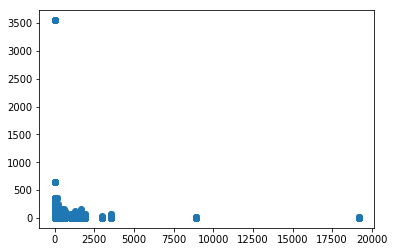

In [56]:
# Calculate product
for key, value in cc_similarity_zero_clean.items():
    cc_similarity_zero_clean[key]=(value[0], value[1], (value[0])*(value[1]))
    

# Print top entries    
top_outliers = dict(sorted(cc_similarity_zero_clean.items(), key=lambda x: x[1][2], reverse=True)[:20])

for key, value in top_outliers.items():
    print(key[0]+ ", "+key[1]+": Follower multiple "+str(value[2]))
    
# PLot all
zerosim_lengths_1 = [lengths[0] for lengths in cc_similarity_zero_clean.values()]
zerosim_lengths_2 = [lengths[1] for lengths in cc_similarity_zero_clean.values()]

plt.scatter(zerosim_lengths_1, zerosim_lengths_2)
plt.show()

There are not many insights that can be gained from this. The only interesting thing to note is the frequency of virtacoin/virtacoinplus (which share the same repository). This indicates that the virtacoin community might be a very isolated group, doing things on their own. We will analyze this further when we get to user communities.

### 3.1.6 Step 5: Analysis of other similarity entries

After covering the borders of the spectrum of similarities, we now get to the core. Let's analyze the currencies that have not entirely similar or dissimilar communities. First, we need to gain this data:

In [60]:
# Get no 0/1 similarities
cc_similarity_nozeroone = dict((k, v) for k, v in cc_similarity.items() if v != 0 and v!=1)

# Print summaries
print("Number of pairs:"+str(len(cc_similarity_nozeroone)))
print("Mean similarity:"+str(np.mean(list(cc_similarity_nozeroone.values()))))
print("")

# Maximal and minimal values
max_sim = dict(sorted(cc_similarity_nozeroone.items(), key=lambda x: x[1], reverse=True)[:10])
print("Maximal similarities:")
for x in max_sim:
    print(str(x)+": Similarity "+str(cc_similarity_nozeroone[(x[0], x[1])]))
    
print("")

min_sim = dict(sorted(cc_similarity_nozeroone.items(), key=lambda x: x[1])[:10])
print("Minimal similarities:")
for x in min_sim:
    print(str(x)+": Similarity "+str(cc_similarity_nozeroone[(x[0], x[1])]))

Number of pairs:6848
Mean similarity:0.0155639742961

Maximal similarities:
('masternodecoin', 'innova'): Similarity 0.5
('audiocoin', 'dfscoin'): Similarity 0.5
('ultracoin', 'steps'): Similarity 0.5
('triangles', 'britcoin'): Similarity 0.5
('triangles', 'ratecoin'): Similarity 0.5
('incakoin', 'steps'): Similarity 0.5
('innova', 'desire'): Similarity 0.4
('dynamic', 'sequence'): Similarity 0.375
('masternodecoin', 'force'): Similarity 0.3333333333333333
('machinecoin', 'fujicoin'): Similarity 0.3333333333333333

Minimal similarities:
('bitcoin', 'blitzcash'): Similarity 5.205351100931758e-05
('bitcoin', 'magi'): Similarity 5.2058930709563226e-05
('bitcoin', 'dynamic'): Similarity 5.207248489897938e-05
('bitcoin', 'memetic'): Similarity 5.207248489897938e-05
('bitcoin', 'arcticcoin'): Similarity 5.20751965838671e-05
('bitcoin', 'ethereum-dark'): Similarity 5.20751965838671e-05
('bitcoin', 'eternity'): Similarity 5.208062080099995e-05
('bitcoin', 'cloakcoin'): Similarity 5.20833333333

For maximal values, we only get very small currencies, whose share one of two or three total users. For minimal values, bitcoin with its huge userbase has a spot in in all top entries (what was to be expected).

Let's explore this further with some plots. First, we want a distribution of the similarities:

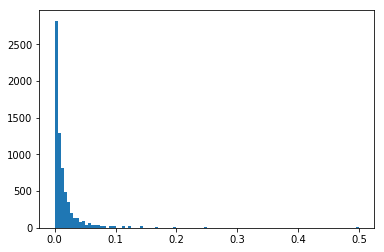

In [61]:
plt.hist(cc_similarity_nozeroone.values(), bins=100)
plt.show()

The values are exponentially distributed, which is no surprise. Also, the overall values are very low. We now want to see if there is a dependency between follower community size and community similarity. Therefore, we plot a pair's combined community size against their similarity:

In [62]:
sim_comm_sizes=[]
for pair in cc_similarity_nozeroone.keys():
    n1=len(set([x.login for x in crypto_stargazers_dict[pair[0]]]))
    n2=len(set([x.login for x in crypto_stargazers_dict[pair[1]]]))
    n12=len(common_user_dict[pair])
    
    sim_comm_sizes.append(n1+n2-n12)
    


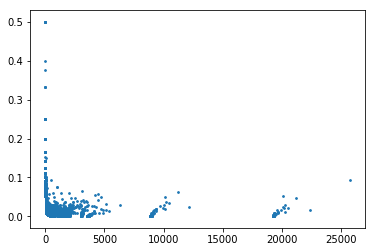

In [63]:
plt.scatter(sim_comm_sizes, cc_similarity_nozeroone.values(), s=3)
plt.show()

Most values bunch up in the bottom, the small currencies' outliers in similarity are clearly visible at the left edge. Also, the points generated by the two biggest currencies bitcoin and ethereum are clearly visible as bunches towards the right. Astonishingly, there seems to be a positive correlation between the second currency's follower base and the similarity.

We thus want to investigate the currencies with big following bases nearer:

### 3.1.7 Step 6: The big fishes

To analyze the big currencies, we need to first get the cc's with the largest following bases:

In [65]:
# Get all currencies' follower counts
cc_follower_count={}
for key, value in crypto_stargazers_dict.items():
    cc_follower_count[key]=len(value)

# Extract the 20 biggest
big_currencies=sorted(cc_follower_count, key=cc_follower_count.get, reverse=True)[:20]

print(big_currencies)

['bitcoin', 'ethereum', 'lbry-credits', 'zcash', 'litecoin', 'siacoin', 'ripple', 'monero', 'dogecoin', 'lisk', 'neo', 'dash', 'steem', 'steem-dollars', 'iota', 'bitshares', 'cardano', 'qtum', 'bitcoin-gold', 'peercoin']


Now we can find the similarity measures for each of these with the other 19 currencies:

In [66]:
# Create dictionary for all big currencies
big_cc_similarity={}
for curr in big_currencies:
    sims=[]
    # Get the 19 other currencies
    other=[x for x in big_currencies if not x==curr]
    for c in other:
        # Followers of second currency
        f=cc_follower_count[c]
        # Similarity of the two currencies
        try:
            s=cc_similarity[(curr, c)]
        except:
            s=cc_similarity[(c, curr)]
        # Build list entry
        sims.append((c, f, s))
    # Build dictionary entry
    big_cc_similarity[curr]=sims
    
print(big_cc_similarity)

{'bitcoin': [('ethereum', 8883, 0.09223886403423459), ('lbry-credits', 3549, 0.016765771001922475), ('zcash', 2980, 0.046340427539993394), ('litecoin', 1932, 0.05141349790961577), ('siacoin', 1755, 0.022502074486259578), ('ripple', 1663, 0.02865598027127004), ('monero', 1417, 0.024608501118568233), ('dogecoin', 1398, 0.02234248547738444), ('lisk', 1276, 0.012214419938680644), ('neo', 1059, 0.016615631745394308), ('dash', 665, 0.016066311911584117), ('steem', 648, 0.011367111836068916), ('steem-dollars', 648, 0.011367111836068916), ('iota', 578, 0.00774759162036801), ('bitshares', 422, 0.009781209781209782), ('cardano', 406, 0.00538627269929209), ('qtum', 369, 0.0069490914706336546), ('bitcoin-gold', 367, 0.006742498327242781), ('peercoin', 314, 0.009313395767579034)], 'ethereum': [('bitcoin', 19193, 0.09223886403423459), ('lbry-credits', 3549, 0.022873128188250783), ('zcash', 2980, 0.06156599552572707), ('litecoin', 1932, 0.03502727533735286), ('siacoin', 1755, 0.04952644041041831), ('

We seemed to oberve a correlation between 2nd currency follower counts and similarity for each currency. This needs to be checked now. Therefore, we calculate the correlation of stargazer count and similarity to all other big repositories for all big currencies:

In [67]:
big_cc_corr={}
for key, value in big_cc_similarity.items():
    # Other follower counts
    f=[x[1] for x in value]
    # Similarities
    s=[x[2] for x in value]
    # Calculate correlation
    big_cc_corr[key]=np.corrcoef(f,s)[0,1]
    
print(big_cc_corr)

{'bitcoin': 0.89767742300277242, 'ethereum': 0.83220629141010927, 'lbry-credits': 0.31652458122177307, 'zcash': 0.46305598182874552, 'litecoin': 0.34680765299101107, 'siacoin': 0.11625349424205783, 'ripple': 0.25428079651226776, 'monero': 0.032817057939772264, 'dogecoin': 0.10012246810957526, 'lisk': -0.12295813567067974, 'neo': -0.20853378409052123, 'dash': -0.32437560673481108, 'steem': -0.12365340975863356, 'steem-dollars': -0.12365340975863356, 'iota': -0.4051362610788527, 'bitshares': -0.34144710228970293, 'cardano': -0.43237566035908009, 'qtum': -0.38220089720814931, 'bitcoin-gold': -0.35769560134738554, 'peercoin': -0.2030773001336329}


The observation mentioned before of positive correlation between followers and similarity only holds for the big currencies. It even completely flips for currencies outside of the top 10. We can visualize that:

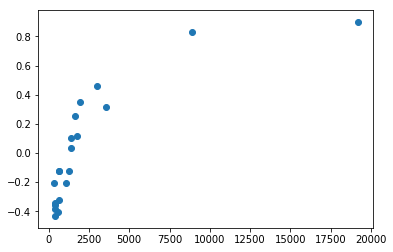

In [68]:
big_followers=[cc_follower_count[curr] for curr in big_cc_corr.keys()]

plt.scatter(big_followers, big_cc_corr.values())
plt.show()

So for the biggest currencies we can say that follower similarity increases with the size of the second currency, for the less big currencies it is the other way around.

### 3.1.8 Summary

This analysis step provides some insight on how similar currency follower groups are. Setting the similarity measuremant to the Jaccard coefficient, we get the following results:
* Some currencies actually share a github repository. They are also normally named similarly.
* Zero similarity is often caused by a currency having no stargazers.
* The currencies virtacoin and virtacoinplus seem to have a follower base that is very distinct from the others
* Not even 10% of all currency pairs share at least one user
* For the biggest 20 cryptocurrencies, some interesting trends can be observed:
    * For the biggest currencies, user similarity is higher with other very big currencies than with smaller ones
    * For a little bit smaller curerncies, it is the other way.

## 3.2 Analyzing followers vs. marketcap

### 3.2.1 Goals

Now we want to add the most important attribute of a cryptocurrency into the mix - its marketcap. We want to discover whether statistics about the github repository of a currency can tell something about its economic value.

### 3.2.2 Step 1: Get the data and add it to the network

We downloaded marketcap values for the cryptocurrencies from [coinmarketcap.com](https://coinmarketcap.com/). Now, we cann add these as node attributes to our graph.

In [71]:
# Load data
with open('./name_marketcap_dict.pickle', 'rb') as handle:
    name_marketcap_dict = pickle.load(handle)
    
# test
print(name_marketcap_dict['bitcoin'])

179941892291


In [72]:
# Add marketcap as node attribute
for name, value in name_marketcap_dict.items():
    try:
        Stargaze_Network.node[name]['marketcap'] = value
    except:
        True

# test
print(Stargaze_Network.node['bitcoin']['marketcap'])

179941892291


### 3.2.3 Step 2: Get an overview over the relationship between marketcap and followers

Now, we can see how the in-degree (stargazer count) and marketcap of a currency depend on each other. First, we simply calculate the correlation between the two values:

In [73]:
star_nos = []
marketcaps = []
for key, value in crypto_stargazers_dict.items():
    star_nos.append(len(value))
    marketcaps.append(name_marketcap_dict[key])
    
print("Correlation between follower count and marcetcap:", np.corrcoef(star_nos, marketcaps)[0,1])
    

Correlation between follower count and marcetcap: 0.942808533959


This looks very good at first glance but plotting the data reveals that bitcoin and ethereum have such a big marketcap and follower basis that it renders the other currencies irrelevant:

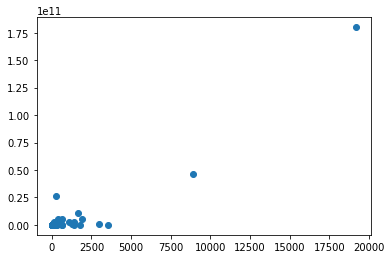

In [74]:
plt.scatter(x=star_nos, y=marketcaps)
plt.show()

When looking at the same plot without the two currencies, we get a totally different picture and a much worse correlation:

Correlation between follower count and marcetcap without bitcoin, ethereum: 0.27329010851


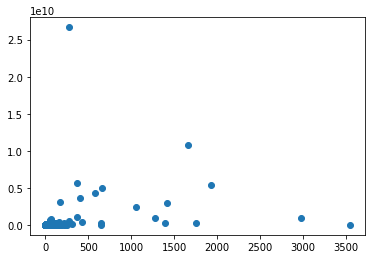

In [75]:
print("Correlation between follower count and marcetcap without bitcoin, ethereum:", np.corrcoef(star_nos[2:], marketcaps[2:])[0,1])

plt.scatter(x=star_nos[2:], y=marketcaps[2:])
plt.show()

We can clearly see that there is no strong dependency between the two variables. Thus, we will try to find other variables that influence the marketcap.

### 3.2.4 Step 3: New variables

We now want to find other variables that could have an impact on marketcap. First, we look at the time a currency's repository was created. We then calculate its age in days (until 3rd December 2017) and compare it to the monetary value. Because bitcoin and ethereum were some of the first currencies and are the biggest, we suspect a correlation.

In [76]:
# Get all repository data
with open('./crypto_repo_dict.pickle', 'rb') as handle:
    crypto_repo_dict = pickle.load(handle)

# Today's date
today = datetime.date.today()
crypto_age_dict = {}

# Get age of currencies
for curr in crypto_repo_dict.keys():
    # Get creation time and Calculate days
    try:
        created = crypto_repo_dict[curr].created_at.date()
        days = (today-created).days
        crypto_age_dict[curr]=days
    except:
        days = None


Correlation between age and marketcap: 0.17400441758


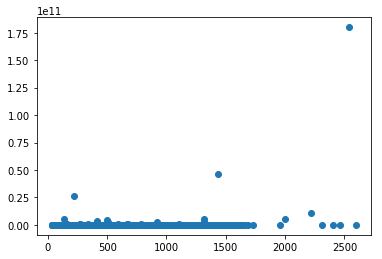

In [77]:
# Make sure that values correspond to the same currency
ages=[]
for key, value in crypto_stargazers_dict.items():
    ages.append(crypto_age_dict[key])

# Correlation    
print("Correlation between age and marketcap:", np.corrcoef(ages, marketcaps)[0,1])

# Plot
plt.scatter(x=ages, y=marketcaps)
plt.show()

There is no good correlation, because many of the old currencies never made it big despite their age. We will therefore put this on ice.

Another idea would be the number of forks. If you want to experiment with code and maybe use it for your purposes, you need to create a fork. The idea is that cryptocurrencies with a high marketcap will have a high number of forks.

In [78]:
crypto_forks_dict = {}

# Get forks of currencies
for curr in crypto_repo_dict.keys():
    try:
        forks = crypto_repo_dict[curr].forks_count
        crypto_forks_dict[curr]=forks
    except:
        forks = None

Correlation between age and marketcap: 0.963190938991


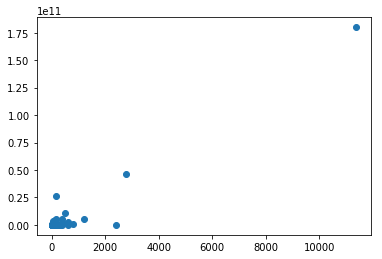

In [79]:
# Make sure that values correspond to the same currency
forks=[]
for key, value in crypto_stargazers_dict.items():
    forks.append(crypto_forks_dict[key])

# Correlation    
print("Correlation between age and marketcap:", np.corrcoef(forks, marketcaps)[0,1])

# Plot
plt.scatter(x=forks, y=marketcaps)
plt.show()

Again, bitcoin and ethereum falsify the result, so we take a closer look at the others:

Correlation between age and marketcap: 0.226278710936


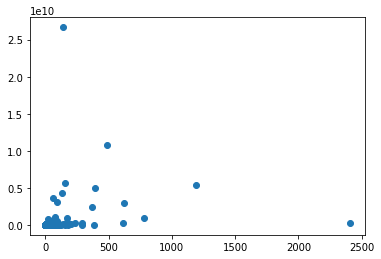

In [52]:
# Correlation    
print("Correlation between age and marketcap:", np.corrcoef(forks[2:], marketcaps[2:])[0,1])

# Plot
plt.scatter(x=forks[2:], y=marketcaps[2:])
plt.show()

This metric is very similar to the follower count. When setting up a regression model to predict the marketcap we thus have to account for multicollinearity.

Now we try our luck at putting all three of these variables into one model to predict the marketcap. We will therefore leave out bitcoin and ethereum, as they are clear outliers.

## 3.3 Community Analysis

In [11]:
# Open the network of GitHub users (and their folloing interactions)
with open('./Following_Network.pickle', 'rb') as handle:
    Following_Network = pickle.load(handle)

In [12]:
# For the python-louvain community partition we need an undirected grah
Following_Network_undirected = Following_Network.to_undirected()
partition = community.best_partition(Following_Network_undirected)

In [33]:
# Check how many communities where partitioned
size = int(len(set(partition.values())))
print('The best partition results in', size, 'communities')

The best partition results in 100 communities


In [16]:
# Dislay the sizes of the 100 communities
community_list = [[] for _ in range(int(size))]
for k,v in partition.items():
    community_list[v].append(k)
print('%22s  | %22s  | %22s  | %22s' % ('Communities 0-24','Communities 25-49','Communities 50-74','Communities 75-99'))
print('---------------------------------------------------------------------------------------------------------')
print('%10s %10s   | %10s %10s   | %10s %10s   | %10s %10s' % ('No.','Size', 'No.','Size', 'No.','Size', 'No.','Size'))
print('---------------------------------------------------------------------------------------------------------')
for i in range(int(size)//4):
    print('%10s %10s   | %10s %10s   | %10s %10s   | %10s %10s' 
          % (str(i), str(len(community_list[i])), str(i+25), str(len(community_list[i+25])),
            str(i+50), str(len(community_list[i+50])), str(i+75), str(len(community_list[i+75]))))

      Communities 0-24  |      Communities 25-49  |      Communities 50-74  |      Communities 75-99
---------------------------------------------------------------------------------------------------------
       No.       Size   |        No.       Size   |        No.       Size   |        No.       Size
---------------------------------------------------------------------------------------------------------
         0       3033   |         25          2   |         50          2   |         75          2
         1        920   |         26          2   |         51          4   |         76          2
         2       3043   |         27          4   |         52          2   |         77          2
         3        810   |         28         11   |         53          2   |         78          2
         4       2424   |         29          2   |         54          3   |         79          2
         5        543   |         30          3   |         55          2   |         8

In [36]:
# Extract the number of small communities (two or three members in the community) 
small_communities = [i for i,community in enumerate(community_list) if len(community) in set([2,3])]
print('There are', len(small_communities), 'communities with only two or three users')

There are 76 communities with only two or three users


From inspection of this table we can see the majority of of users a classed in few large communities. Now we need to understand the differences in the communities. 

This  will  be  carried out by:
1. For each community calculating how many users in the community starred each  crypto-currency
2. Calculating how many users of the  whole network starred each crypto-currency
3. Dividing the number of stars a crypto-currency has in a community by the number of stars the crypto-currency has in the whole network and then normalising for each group. 
4. The result is a value for each crypto-currency in each community that indicates the skews of the community. For example a value of '2.0' for group 1, crypto-currency 'Bitcoin', means the community has relativley starred the bitcoin repository twice as much compared to the whole network.

This means we can detect the skews of a community towards certain crypto-currencies. 

In [26]:
# For a given communities find the relative "starring" of crypto-currencies in the community
Stargaze_Network_undirected = Stargaze_Network.to_undirected()
user_neighbors_dict = {}
currencies_degree_dict = {}

for node, data in Stargaze_Network.nodes(data=True):
    if data["Type"]=="User":
         user_neighbors_dict[node] = list(Stargaze_Network_undirected.neighbors(node))
    elif data["Type"]=="Currency":
        currencies_degree_dict[node] = Stargaze_Network.degree(node)

total_number_of_stars = sum(currencies_degree_dict.values())
currencies_degree_dict = {k:v/total_number_of_stars for k,v in currencies_degree_dict.items()}

In [27]:
community_stars_compilation_dict = {i:{} for i in range(int(size))}

In [28]:
for i,community in enumerate(community_list):
    for member in community:
        if member in user_neighbors_dict.keys():
            for currency in user_neighbors_dict[member]:
                try:
                    if name_marketcap_dict[currency] > 5000000:
                        try:
                            community_stars_compilation_dict[i][currency] += 1
                        except KeyError:
                            community_stars_compilation_dict[i][currency] = 1
                except:
                    pass

In [29]:
community_star_total = [sum(currency_star_dict.values()) for currency_star_dict in community_stars_compilation_dict.values()]

In [30]:
with open('./name_marketcap_dict.pickle', 'rb') as handle:
    name_marketcap_dict = pickle.load(handle)

In [31]:
for i in community_stars_compilation_dict.keys():
    for currency in community_stars_compilation_dict[i].keys():
        try:
            community_stars_compilation_dict[i][currency] = (community_stars_compilation_dict[i][currency]/community_star_total[i])/currencies_degree_dict[currency]
        except:
            community_stars_compilation_dict[i][currency] = None

Below

In [32]:
for i in range(len(community_stars_compilation_dict)):
    if i not in set(small_communities):
        temp = []
        for k,v in community_stars_compilation_dict[i].items():
            if v is not None and float(v) > 5:
                temp.append((k,float(v)))
        if len(temp) > 0 and len(community_list[i]) > 100:
            print('Community', i, '('+str(len(community_list[i]))+')')
            for k,v in sorted(temp,key=lambda x: x[1],  reverse=True)[:10]:
                print(k,v)
            print('--------------------------------------------------')

Community 1 (920)
bitcoindark 9.007846829880728
bitcoin-plus 8.107062146892655
centurion 8.107062146892655
exclusivecoin 5.790758676351897
sibcoin 5.404708097928436
bitbay 5.06691384180791
casinocoin 5.06691384180791
--------------------------------------------------
Community 2 (3043)
salus 10.347575265909501
energycoin 5.173787632954751
bridgecoin 5.173787632954751
pinkcoin 5.173787632954751
masternodecoin 5.173787632954751
--------------------------------------------------
Community 3 (810)
posw-coin 13.49905926622766
cloakcoin 6.74952963311383
riecoin 5.999581896101181
--------------------------------------------------
Community 4 (2424)
rise 7.733495014820803
bridgecoin 7.733495014820803
--------------------------------------------------
Community 5 (543)
monacoin 17.19418186659566
centurion 14.137438423645321
sexcoin 7.854132457580733
--------------------------------------------------
Community 6 (218)
goldblocks 48.56006768189509
karbowanec 29.136040609137055
prizm 24.2800338409